# Social Graphs and Interactions final assignment

This project is about the *Game of Throne* TV show. 

In [9]:
import numpy as np
import pandas as pd
import random as rd
import matplotlib.pyplot as plt
import urllib.request
import json
import requests
import re
import networkx as nx
import os
import powerlaw as pl
import statistics as st
import scipy.stats as sc
import nltk
import community.community_louvain as ccl

from fa2 import ForceAtlas2
from collections import Counter
from urllib.parse import urlparse, quote
from fa2 import ForceAtlas2
from wordcloud import WordCloud
from nltk.draw import dispersion_plot

import warnings
warnings.filterwarnings("ignore")

## Characters network analysis

In [3]:
# Save wiki content from characters into txt files
# Text is cleaned from html tags and so on
# Only run once if necessary

'''
# One characters dataset, used to get the wiki pages
f = open('characters.json')

data_chars = json.load(f)
data_chars = data_chars["characters"]

char_list = [char["characterName"] for char in data_chars]
char_list.append("Wight") # Add this important character because it was not in the json file

baseurl = " http://gameofthrones.wikia.com/api.php?"
action = "action=query"
content = "prop=revisions&rvprop=content"
dataformat ="format=json"

for char in char_list:
    #name = char.replace('-','_')
    name = char.replace(' ','_')
    name = name.split("_#")[0]
    
    title = f"titles={name}"
    query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)

    wikiresponse = urllib.request.urlopen(query)
    wikidata = wikiresponse.read()
    dat = wikidata.decode('utf-8')
    data = json.loads(dat)['query']['pages']
    data = data[list(data.keys())[0]]
    data = data[list(data.keys())[-1]]
    if len(data) > 0:
        data = data[0]["*"]
        data = re.sub("<.*?>","",data)
        data = re.sub("{","",data)
        data = re.sub("}","",data)
        data = re.sub("\n"," ",data)
        if data[:12] == "#REDIRECT [[":
            name = re.findall(r'\[\[([\w\s\(\)-._@\',#:"!&=\\]+)[\|\]\]]', data)[0]
            name = name.replace(" ", "_")
            title = f"titles={name}"
            query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
            wikiresponse = urllib.request.urlopen(query)
            wikidata = wikiresponse.read()
            dat = wikidata.decode('utf-8')
            data = json.loads(dat)['query']['pages']
            data = data[list(data.keys())[0]]
            data = data[list(data.keys())[-1]]
            data = data[0]["*"]
            data = re.sub("<.*?>","",data)
            data = re.sub("{","",data)
            data = re.sub("}","",data)
            data = re.sub("\n"," ",data)
        if data[:11] == "#REDIRECT[[":
            name = re.findall(r'\[\[([\w\s\(\)-._@\',#:"!&=\\]+)[\|\]\]]', data)[0]
            name = name.replace(" ", "_")
            title = f"titles={name}"
            query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
            wikiresponse = urllib.request.urlopen(query)
            wikidata = wikiresponse.read()
            dat = wikidata.decode('utf-8')
            data = json.loads(dat)['query']['pages']
            data = data[list(data.keys())[0]]
            data = data[list(data.keys())[-1]]
            data = data[0]["*"]
            data = re.sub("<.*?>","",data)
            data = re.sub("{","",data)
            data = re.sub("}","",data)
            data = re.sub("\n"," ",data)
        if data[:13] == " #REDIRECT [[":
            name = re.findall(r'\[\[([\w\s\(\)-._@\',#:"!&=\\]+)[\|\]\]]', data)[0]
            name = name.replace(" ", "_")
            title = f"titles={name}"
            query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
            wikiresponse = urllib.request.urlopen(query)
            wikidata = wikiresponse.read()
            dat = wikidata.decode('utf-8')
            data = json.loads(dat)['query']['pages']
            data = data[list(data.keys())[0]]
            data = data[list(data.keys())[-1]]
            data = data[0]["*"]
            data = re.sub("<.*?>","",data)
            data = re.sub("{","",data)
            data = re.sub("}","",data)
            data = re.sub("\n"," ",data)
        name = name.replace("_", " ")
        with open(f"GoT wikis/{name}.txt", "w") as file:
            file.write(data)
        file.close()
'''

'\n# One characters dataset, used to get the wiki pages\nf = open(\'characters.json\')\n\ndata_chars = json.load(f)\ndata_chars = data_chars["characters"]\n\nchar_list = [char["characterName"] for char in data_chars]\nchar_list.append("Wight") # Add this important character because it was not in the json file\n\nbaseurl = " http://gameofthrones.wikia.com/api.php?"\naction = "action=query"\ncontent = "prop=revisions&rvprop=content"\ndataformat ="format=json"\n\nfor char in char_list:\n    #name = char.replace(\'-\',\'_\')\n    name = char.replace(\' \',\'_\')\n    name = name.split("_#")[0]\n    \n    title = f"titles={name}"\n    query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)\n\n    wikiresponse = urllib.request.urlopen(query)\n    wikidata = wikiresponse.read()\n    dat = wikidata.decode(\'utf-8\')\n    data = json.loads(dat)[\'query\'][\'pages\']\n    data = data[list(data.keys())[0]]\n    data = data[list(data.keys())[-1]]\n    if len(data) > 0:\n       

In [50]:
# List of all characters for whom we downloaded the wiki page
chars_list = os.listdir("GoT wikis")
#chars_list.remove(".DS_Store")
chars_list = [char[:-4] for char in chars_list]
print(f"Number of characters used : {len(chars_list)}")

def find_links(page_content):
    # Get links from the page content
    wiki_links = re.findall(r'\[\[([\w\s\)-._\']+)[\|\]\]]', page_content)
    
    # Only keep the links that correspond to other marvel/DC characters
    char_links = []
    for link in wiki_links:
        if link in chars_list:
            char_links.append(link)
        if link == "wight":
            char_links.append("Wight")
    return char_links

Number of characters used : 276


In [51]:
# Make graph out of it
G = nx.DiGraph()

# Dictionnaries with nodes attributes
lengths = {}
words = {}

for char in chars_list:
    G.add_node(char)
    file = open(f"GoT wikis/{char}.txt", "r")
    neighbours = find_links(file.read())
    file.close()
    
    lengths[char] = len(neighbours)
    counts = Counter(neighbours)
    
    for nb in counts:
        G.add_edge(char, nb, weight=counts[nb])  # Add edges with strength attributes

for char in chars_list:
    f = open(f"GoT wikis/{char}.txt", "r")
    words_list = re.findall(r"[\w']+", f.read())
    f.close()
    words[char] = len(words_list)

nx.set_node_attributes(G, lengths, "length")
nx.set_node_attributes(G, words, "words")
        
print(f"Number of nodes : {len(list(G.nodes()))}")
print(f"Number of edges : {len(list(G.edges()))}")

Number of nodes : 276
Number of edges : 5470


In [52]:
# Assign each character their house if they have any
houses = {}

for char in chars_list:
    f = open(f"GoT wikis/{char}.txt")
    h = re.findall(r'Allegiance  = \[\[([\w\s\)-._\'/]+)[\|\]\]]', f.read())    
    f.close()
    if len(h) > 0 and h[0][:5] == "House":
        house = h[0].split(" of")[0]
        house = house.split("/")[0]
        houses[char] = house
    else:
        f = open(f"GoT wikis/{char}.txt")
        h = re.findall(r'Allegiance=\[\[([\w\s\)-._\']+)[\|\]\]]', f.read())
        f.close()
        if len(h) > 0 and h[0][:5] == "House":
            house = h[0].split(" of")[0]
            house = house.split("/")[0]
            houses[char] = house

nx.set_node_attributes(G, houses, "house")

In [53]:
# List of characters without a house - to be checked
chars_without_house = list(chars_list)
for char in houses:
    chars_without_house.remove(char)
    
print("Number of characters without a house :",len(chars_without_house))

# List of all houses used
houses_list = list(set(houses.values()))
print("Number of houses :", len(houses_list))

# Randomly attribute a color for each house
houses_colors = {}
for house in houses_list:
    houses_colors[house] = "#"+''.join([rd.choice('abcdef0123456789') for i in range(6)])
#houses_colors["no house"] = "#b6b6b6"

Number of characters without a house : 116
Number of houses : 52


The code below is useful to draw the network.
Each house is attributed a random color, and the characters without a house are printed in grey.
The nodes of the characters with highest degree are labeled with their names, it is also useful to know whiich color corresponds to which house.

In [54]:
# Set colors to each node
random_nodes_colors = []
for node in G.nodes():
    if node in chars_without_house:
        random_nodes_colors.append("#b6b6b6")
    else:
        random_nodes_colors.append(houses_colors[houses[node]])

# Define nodes sizes
nodes_sizes = list(dict(G.degree()).values())
nodes_sizes = [4*ns for ns in nodes_sizes]

# Define edges width
edges_weights = list(nx.get_edge_attributes(G, "weight").values())
edges_weights = [ew*1.5 for ew in edges_weights]

# Label some important nodes
labels = {
    "Tyrion Lannister": "Tyrion Lannister",
   "Jon Snow": "Jon Snow",
   "Daenerys Targaryen": "Daenerys Targaryen",
   "Arya Stark": "Arya Stark",
   "Sansa Stark": "Sansa Stark",
   "Eddard Stark": "Eddard Stark",
   "Jaime Lannister": "Jaime Lannister",
   "Cersei Lannister": "Cersei Lannister",
   "Robb Stark": "Robb Stark",
   "Bran Stark": "Bran Stark",
   "Robert Baratheon": "Robert Baratheon",
}

100%|██████████████████████████████████████| 2000/2000 [00:03<00:00, 614.60it/s]


BarnesHut Approximation  took  0.80  seconds
Repulsion forces  took  1.98  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  0.06  seconds
AdjustSpeedAndApplyForces step  took  0.16  seconds


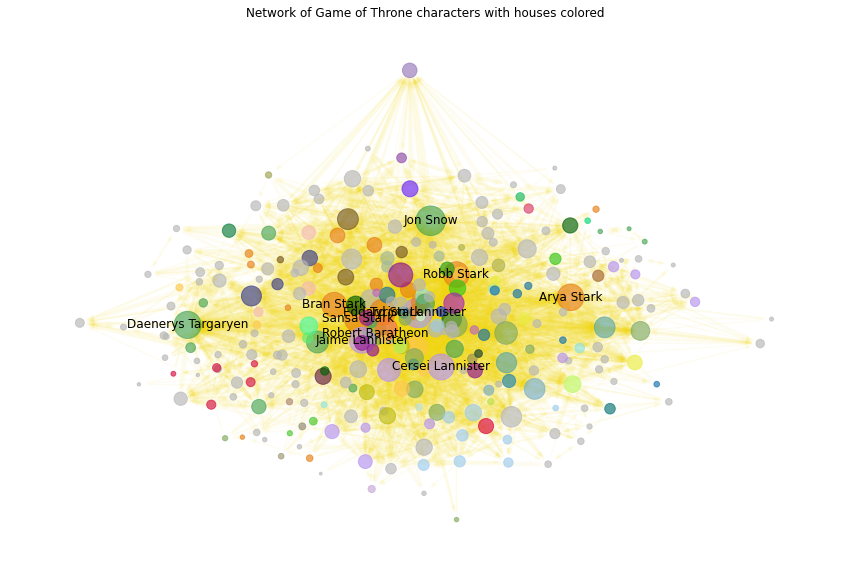

In [55]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=250.0,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)

plt.figure(figsize=(15,10))
plt.title("Network of Game of Throne characters with houses colored")
nx.draw_networkx_nodes(G, positions, node_size=nodes_sizes, node_color=random_nodes_colors, alpha=0.65)
nx.draw_networkx_edges(G, positions, edge_color="#EED200", width=edges_weights, alpha=0.05)
nx.draw_networkx_labels(G, positions, labels=labels)
plt.axis('off')
plt.show()

Some basic stats and the degree distributions of the networks were calculated below.

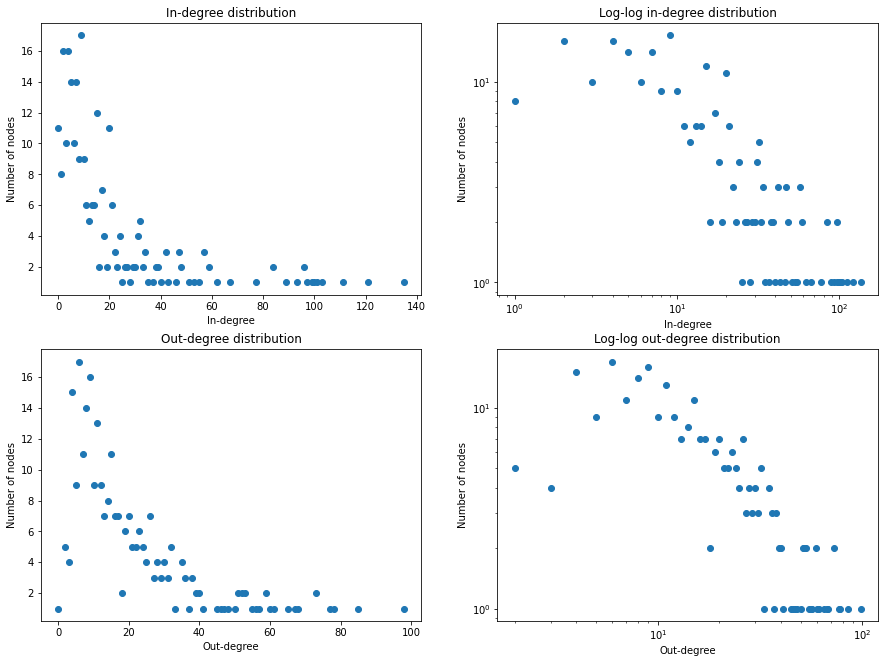

In [56]:
in_degs = list(dict(G.in_degree()).values())
out_degs = list(dict(G.out_degree()).values())

count_in = Counter(in_degs)
count_out = Counter(out_degs)

fig, axs = plt.subplots(2, 2, figsize=(15,11))

axs[0,0].plot(list(count_in.keys()), list(count_in.values()), 'o')
axs[0,0].set_ylabel("Number of nodes")
axs[0,0].set_xlabel("In-degree")
axs[0,0].set_title("In-degree distribution")
axs[0,1].plot(list(count_in.keys()), list(count_in.values()), 'o')
axs[0,1].set_xscale('log')
axs[0,1].set_yscale('log')
axs[0,1].set_title("Log-log in-degree distribution")
axs[0,1].set_ylabel("Number of nodes")
axs[0,1].set_xlabel("In-degree")

axs[1,0].plot(list(count_out.keys()), list(count_out.values()), 'o')
axs[1,0].set_ylabel("")
axs[1,0].set_xlabel("Out-degree")
axs[1,0].set_ylabel("Number of nodes")
axs[1,0].set_title("Out-degree distribution")
axs[1,1].plot(list(count_out.keys()), list(count_out.values()), 'o')
axs[1,1].set_xscale('log')
axs[1,1].set_yscale('log')
axs[1,1].set_ylabel("Number of nodes")
axs[1,1].set_xlabel("Out-degree")
axs[1,1].set_title("Log-log out-degree distribution")

plt.show()

In [57]:
# Top 20 in-degree nodes
top_20_in = list({key: val for key, val in sorted(dict(G.in_degree()).items(), key = lambda ele: ele[1], reverse=True)})[:20]
print("Top 20 in-degree characters :")
for char in top_20_in:
    print("  ",char, dict(G.in_degree())[char])

# Top 20 out-degree nodes
top_20_out = list({key: val for key, val in sorted(dict(G.out_degree()).items(), key = lambda ele: ele[1], reverse=True)})[:20]
print("\nTop 20 out-degree characters :")
for char in top_20_out:
    print("  ",char, dict(G.out_degree())[char])

# Top 20 global degree nodes
top_20_glob = list({key: val for key, val in sorted(dict(G.degree()).items(), key = lambda ele: ele[1], reverse=True)})[:20]
print("\nTop 20 global-degree characters :")
for char in top_20_glob:
    print("  ",char, dict(G.degree())[char])

Top 20 in-degree characters :
   Tyrion Lannister 135
   Jon Snow 121
   Daenerys Targaryen 111
   Cersei Lannister 103
   Eddard Stark 101
   Sansa Stark 100
   Arya Stark 99
   Robb Stark 97
   Bran Stark 96
   Jaime Lannister 96
   Stannis Baratheon 93
   Robert Baratheon 89
   Catelyn Stark 84
   Tywin Lannister 84
   Joffrey Baratheon 77
   Petyr Baelish 67
   Varys 62
   Wight 59
   Theon Greyjoy 59
   Gregor Clegane 57

Top 20 out-degree characters :
   Jon Snow 98
   Tyrion Lannister 85
   Arya Stark 78
   Sansa Stark 77
   Daenerys Targaryen 73
   Jaime Lannister 73
   Robb Stark 68
   Eddard Stark 67
   Cersei Lannister 65
   Catelyn Stark 61
   Davos Seaworth 60
   Bran Stark 59
   Varys 59
   Petyr Baelish 57
   Robert Baratheon 56
   Brienne of Tarth 55
   Jorah Mormont 53
   Bronn 53
   Stannis Baratheon 52
   Samwell Tarly 52

Top 20 global-degree characters :
   Tyrion Lannister 220
   Jon Snow 219
   Daenerys Targaryen 184
   Arya Stark 177
   Sansa Stark 177
   Jaime 

In [58]:
glob_degs = list(dict(G.degree()).values())

in_exp = pl.Fit(list(Counter(in_degs).values())).alpha
out_exp = pl.Fit(list(Counter(out_degs).values())).alpha
tot_exp = pl.Fit(list(Counter(glob_degs).values())).alpha

print(f"Global exponent: {tot_exp}\nIn-exponent: {in_exp}\nOut-exponent: {out_exp}")

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Global exponent: 6.314236124068233
In-exponent: 2.0203426109639624
Out-exponent: 3.8675103746202284


In [59]:
# Global in-degree
print(f"Global in-degree statistics :\nAverage: {np.mean(in_degs)}\nMedian: {st.median(in_degs)}\nMode: {st.mode(in_degs)}\nMinimum: {np.min(in_degs)}\nMaximum: {np.max(in_degs)}")

# Global out-degree
print(f"\nGlobal out-degree statistics :\nAverage: {np.mean(out_degs)}\nMedian: {st.median(out_degs)}\nMode: {st.mode(out_degs)}\nMinimum: {np.min(out_degs)}\nMaximum: {np.max(out_degs)}")

Global in-degree statistics :
Average: 19.818840579710145
Median: 11.0
Mode: 9
Minimum: 0
Maximum: 135

Global out-degree statistics :
Average: 19.818840579710145
Median: 14.5
Mode: 6
Minimum: 0
Maximum: 98


In [60]:
# Are there any nodes with high out-degree and with few incoming connections? 
# If yes, open WikiPages of such characters and explain what happens?
out_degs_list = dict(G.out_degree())
in_degs_list = dict(G.in_degree())

out_minus_in_deg = {}
for char in list(out_degs_list.keys()):
    out_minus_in_deg[char] = out_degs_list[char] - in_degs_list[char]

sorted_out_minus_in = list({key: val for key, val in sorted(out_minus_in_deg.items(), key = lambda ele: ele[1], reverse=True)})
i = 0
while out_minus_in_deg[sorted_out_minus_in[i]] > 15:
    print(f"{sorted_out_minus_in[i]}  {out_minus_in_deg[sorted_out_minus_in[i]]}")
    i+=1

Locke  20
Robett Glover  17
Ghost  16


#### Who are those characters ?
* *Locke* northern man, he his the man in charge of finding Jaime Lannister when he escapes the Starks. He is also involved in Ramsay Bolton's attemp to capture Bran Stark and infiltrates the Night's Watch for that. He plays an major role in two important events of the serie, which makes him interact with a lot of people, but without being very important himself. Plus the two events involve different characters but are both very link to one of the most powerful house of game of throne (the Starks or the Lannisters).
* *Robett Glover* is a sujbect Lord of the North. For him, the reason is probably that eventhough he is not an important character, he participates in the war against the White Walkers in which most characters also participate.
* *Ghost* is Jon Snow's albinos direwolf. He spends most of his time with Jon Snow, and is important for him. Plus, he his very useful to scare opponents.

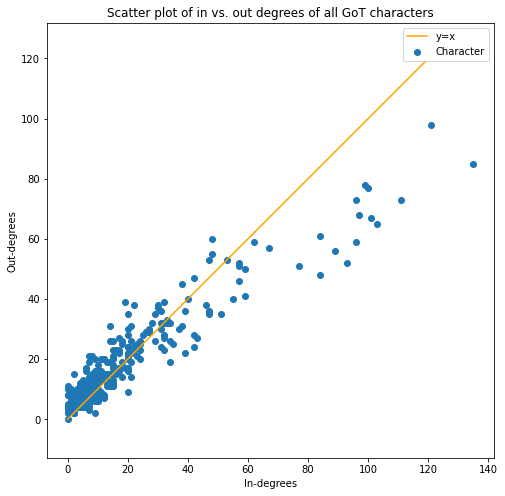

In [61]:
line = list(range(0,120))

plt.figure(figsize=(8,8))
plt.scatter(in_degs, out_degs, label="Character")
plt.plot(line, line, color='orange', label='y=x')
plt.axis("equal")
plt.legend()
plt.xlabel("In-degrees")
plt.ylabel("Out-degrees")
plt.title("Scatter plot of in vs. out degrees of all GoT characters")
plt.show()

Correlation coefficient between the number of words and the out-degree : 0.904358452657907
Pearson correlation coefficient : PearsonRResult(statistic=0.9043584526579065, pvalue=2.512656733131974e-103)
Spearman correlation coefficient : SpearmanrResult(correlation=0.8721562448415956, pvalue=4.650943043997842e-87)


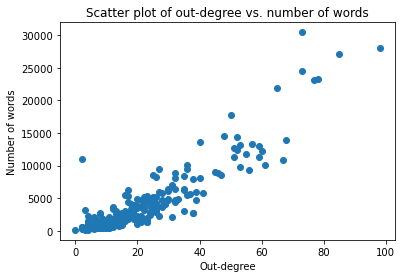

In [62]:
GU = G.to_undirected()

# Studying links between out-degree and number of words
words_list = list(nx.get_node_attributes(GU,'words').values())
#print(words)
cor = np.corrcoef(words_list, out_degs)
pearson = sc.pearsonr(words_list, out_degs)
spearman = sc.spearmanr(words_list, out_degs)

print(f"Correlation coefficient between the number of words and the out-degree : {cor[0,1]}")
print(f"Pearson correlation coefficient : {pearson}")
print(f"Spearman correlation coefficient : {spearman}")

# This is a very high correlation !

plt.figure()
plt.scatter(out_degs, words_list)
plt.title("Scatter plot of out-degree vs. number of words")
plt.xlabel("Out-degree")
plt.ylabel("Number of words")
plt.show()

Correlation coefficient between the numer of words and the in-degree : 0.904358452657907
Pearson correlation coefficient : PearsonRResult(statistic=0.9178534773976468, pvalue=5.808081576180259e-112)
Spearman correlation coefficient : SpearmanrResult(correlation=0.8808993817326811, pvalue=5.31608050691493e-91)


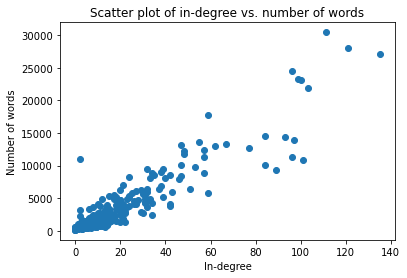

In [63]:
# Studying links between in-degree and number of wordscor = np.corrcoef(words, in_degs)
pearson = sc.pearsonr(words_list, in_degs)
spearman = sc.spearmanr(words_list, in_degs)

print(f"Correlation coefficient between the numer of words and the in-degree : {cor[0,1]}")
print(f"Pearson correlation coefficient : {pearson}")
print(f"Spearman correlation coefficient : {spearman}")

plt.figure()
plt.scatter(in_degs, words_list)
plt.title("Scatter plot of in-degree vs. number of words")
plt.xlabel("In-degree")
plt.ylabel("Number of words")
plt.show()

### Characters centrality

It seems that not matter which centrality type is used (eigenvector, betweeness or degree), the most central characters always include the same characters (Tyrion Lannister, Jon Snow).

5 most central characters for degree centrality :
 ['Tyrion Lannister', 'Jon Snow', 'Daenerys Targaryen', 'Arya Stark', 'Sansa Stark']
5 most central characters for betweeness centrality :
 ['Daenerys Targaryen', 'Jon Snow', 'Tyrion Lannister', 'Arya Stark', 'Bran Stark']
5 most central characters for eigenvector centrality :
 ['Tyrion Lannister', 'Jon Snow', 'Cersei Lannister', 'Jaime Lannister', 'Sansa Stark']


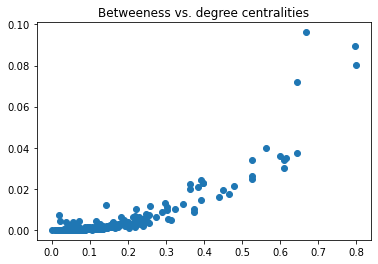

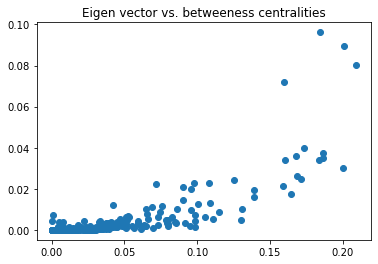

In [64]:
# Study of centralities on the whole graph

# Degree centrality
centr = nx.degree_centrality(G)
top5_central = top_5_in_deg = list({key: val for key, val in sorted(centr.items(), key = lambda ele: ele[1], reverse=True)})[0:5]
print("5 most central characters for degree centrality :\n", top5_central)

# Betweeness centrality
betw_centrality = nx.betweenness_centrality(G)
top5_central = top_5_in_deg = list({key: val for key, val in sorted(betw_centrality.items(), key = lambda ele: ele[1], reverse=True)})[0:5]
print("5 most central characters for betweeness centrality :\n", top5_central)

# Eigenvector centrality
eigen_centrality = nx.eigenvector_centrality(G)
top5_central = list({key: val for key, val in sorted(eigen_centrality.items(), key = lambda ele: ele[1], reverse=True)})[0:5]
print("5 most central characters for eigenvector centrality :\n", top5_central)

plt.figure()
plt.scatter(centr.values(), betw_centrality.values())
plt.title("Betweeness vs. degree centralities")
plt.show()

plt.figure()
plt.scatter(eigen_centrality.values(), betw_centrality.values())
plt.title("Eigen vector vs. betweeness centralities")
plt.show()

### Average shortest path length

In [65]:
# Degree assortativity coefficient
deg_assort = nx.degree_assortativity_coefficient(GU)
print("Degree assortativity :",deg_assort)

# Assortativity of words ie do nodes with a high number of words tend to link with nodes with also high number of words
words_assort = nx.attribute_assortativity_coefficient(GU, "words")
print("Words assortativity",words_assort)

# Biggest CC of DC graph
mCC = max(nx.connected_components(GU), key=len)
BCC = GU.subgraph(mCC).copy()

# Average shortest path length
aspl = nx.average_shortest_path_length(BCC)

print(f"Average shortest path length in DC graph: {aspl}")

Degree assortativity : -0.14617006589638706
Words assortativity -0.006524371169649406
Average shortest path length in DC graph: 2.1311745189117453


ER parameters : N=276, k=26.471014492753625, p=0.09625823451910409


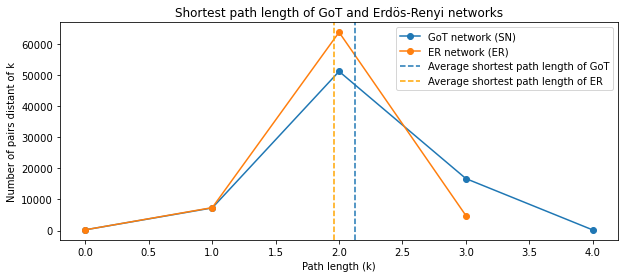

In [66]:
# Compare the graph with an Erdos-Renyi network
N = len(GU.nodes())
k =  np.mean(list(dict(GU.degree()).values()))
p = k/(N-1)
print(f"ER parameters : N={N}, k={k}, p={p}")

ER = nx.erdos_renyi_graph(N, p)

sp_GoT = list(nx.shortest_path_length(GU))
sp_GoT = [list(b.values()) for (_,b) in sp_GoT]
sp_GoT = [item for liste in sp_GoT for item in liste]

sp_ER = list(nx.shortest_path_length(ER))
sp_ER = [list(b.values()) for (_,b) in sp_ER]
sp_ER = [item for liste in sp_ER for item in liste]

# Count the number of nodes for all degrees
C_GoT = Counter(sp_GoT)
C_ER = Counter(sp_ER)

# Degree distributions plot
plt.figure(figsize=(10,4))
plt.plot(list(C_GoT.keys()), list(C_GoT.values()), '-o', label="GoT network (SN)")
plt.plot(list(C_ER.keys()), list(C_ER.values()), '-o', label="ER network (ER)")
plt.axvline(x=np.mean(sp_GoT), linestyle="--", label="Average shortest path length of GoT")
plt.axvline(x=np.mean(sp_ER), linestyle="--", label="Average shortest path length of ER", color='orange')
plt.title("Shortest path length of GoT and Erdös-Renyi networks")
plt.xlabel("Path length (k)")
plt.ylabel("Number of pairs distant of k")
plt.legend()
plt.show()

## Communities & sentiment analysis

In [85]:
# Partition the network into communities
# The analysis wsa made with 9 communities but the number of communities may vary if you rerun this cell
part = ccl.best_partition(GU)
mod = ccl.modularity(part, GU)
nc = np.unique(list(part.values())).shape[0]

print(f"Modularity of the partitionned graph : {mod}")
print("Number of communities in the partition : ", nc)


c = Counter(part.values())

# Keep only communities of more than 1 element
coms_tokeep = []
for com in c:
    if c[com] > 1:
        coms_tokeep.append(com)

print(coms_tokeep)
nc = len(coms_tokeep)
nc

Modularity of the partitionned graph : 0.34848204589620485
Number of communities in the partition :  9
[0, 2, 4, 5, 3, 8, 6, 1]


8

100%|██████████████████████████████████████| 2000/2000 [00:04<00:00, 499.26it/s]


BarnesHut Approximation  took  1.18  seconds
Repulsion forces  took  2.25  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.10  seconds
AdjustSpeedAndApplyForces step  took  0.18  seconds


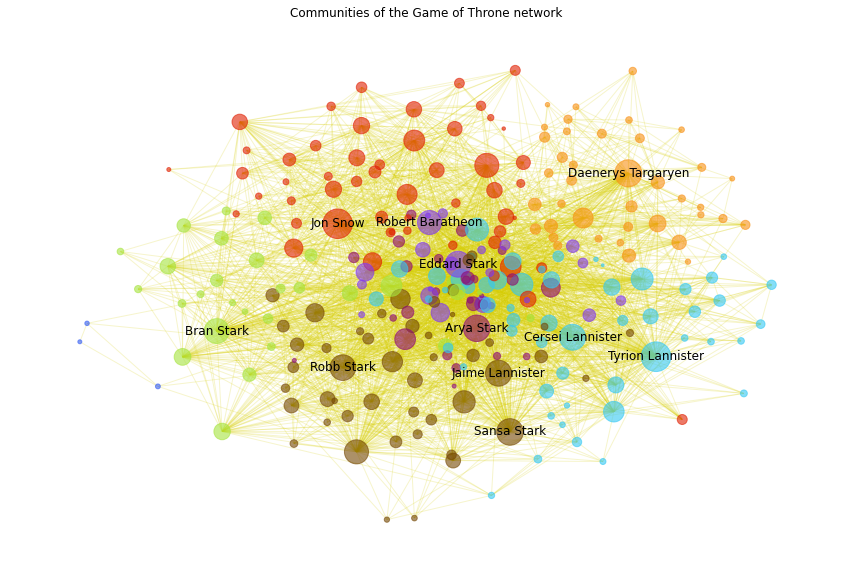

In [86]:
# Plot the partitionned graph with a color per community
possible_colors = ["#8F0C75", "#355EF3", "#35C8F3", "#A6E43F", "#F89116", "#E02002", "#8138F3", "#65A88C", 
                   "#754804", "#185507", "#E79EE2", "#1D9CE4", "#F77777", "#4B0093"]

nodes_colors = []
for node in GU.nodes():
    nodes_colors.append(possible_colors[part[node]])
    
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=300.0,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(GU, pos=None, iterations=2000)

plt.figure(figsize=(15,10))
plt.title("Communities of the Game of Throne network")
nx.draw_networkx_nodes(GU, positions, node_size=nodes_sizes, node_color=nodes_colors, alpha=0.6)
nx.draw_networkx_edges(GU, positions, edge_color="#D5CC00", alpha=0.2)
nx.draw_networkx_labels(G, positions, labels=labels)
plt.axis('off')
plt.show()

### Perform TF-IDF for the communities
By doing this, we manage to extract some important words for each community, and thus understand what links the characters into them.

In [87]:
### TF-IDF by community

# Dictionnary with the list of words of each community
com_words = {}

# Initialize with empty list
for com in coms_tokeep:
    com_words[com] = []

# Fill in all the lists with words from every page
for char in chars_list:
    if part[char] in coms_tokeep:
        char_name = char.split("#")[0].split("/")[0]
        f = open(f'GoT wikis/{char_name}.txt')
        words = re.findall(r"\w+", f.read())[6:]
        node_name = char.split("#")[0].split("|")[0]
        com_words[part[node_name]] = com_words[part[node_name]] + words

# Lower case all the words
for com in coms_tokeep:
    com_words[com] = [w.lower() for w in com_words[com]]

In [88]:
### Create a dictionnary with the IDF of all the words from the top 10 communities
IDF = {}

re_run_idf = False   # Put to True to regenerate the idf of each word of the 10 commnities

if re_run_idf:
    # List of unique words from the 10 communities
    all_words = []
    for com in coms_tokeep:
        all_words = all_words + com_words[com]
    all_words = list(set(all_words))

    # Calculate the IDF of every word in the 10 communities
    # /!\/!\ very long to run /!\/!\

    for w in all_words:
        d = 0
        for com in coms_tokeep:
            if w in com_words[com]:
                d += 1
        IDF[w] = np.log(nc/d)

    # Save IDF dict to txtfile
    with open("IDF.txt", "w") as file:
        for word in IDF:
            file.write(word+";"+str(IDF[word])+"\n")
        file.close()

else:
    # Get the IDF dictionnary from the text file where it is stored
    with open("IDF.txt", "r") as file:
        for line in file:
            sp = line.split(";")
            IDF[sp[0]] = float(sp[1][:-1])
        file.close()

In [89]:
# Now calculate the TF-IDF for all the words in all the communities
TFIDF = {}
for com in coms_tokeep:
    TFIDF_com = {}
    TF_com = dict(nltk.FreqDist(com_words[com]))
    for w in list(TF_com.keys()):
        TFIDF_com[w] = TF_com[w]*IDF[w]
    TFIDF_com = {key: val for key, val in sorted(TFIDF_com.items(), key = lambda ele: ele[1], reverse=True)}
    TFIDF[com] = TFIDF_com

# Print top 10 TF-IDF words for each community
for com in coms_tokeep:
    print(f"Top 10 highest TF-IDF in community {com} :")
    for w in list(TFIDF[com].keys())[:10]:
        print("  ",w, TFIDF[com][w])
    print('')

Top 10 highest TF-IDF in community 0 :
   arya 192.9528623424351
   jaqen 167.0484705149468
   waif 141.40202483422883
   pie 108.82410734791141
   lommy 108.13096016735146
   beric 79.40025199669151
   crane 79.01877858383376
   yoren 73.7905697915805
   polliver 72.78045395879425
   sandor 72.64107758774028

Top 10 highest TF-IDF in community 2 :
   ellaria 357.6639451689318
   tyrion 353.45759627711124
   margaery 352.032718305056
   doran 337.40526303603383
   tyene 324.39288050205437
   shae 292.2871173974944
   obara 262.0096342516593
   lancel 256.97726428907225
   areo 232.8974526681416
   loras 189.2948036732718

Top 10 highest TF-IDF in community 4 :
   daario 358.0026773492801
   drogo 264.08907579333913
   irri 255.7713096266198
   jorah 231.2963862512318
   hizdahr 169.68346077102862
   doreah 169.12791205662666
   xaro 146.1435586987472
   rakharo 138.62943611198907
   pyat 126.15278686191004
   pree 123.38019813967026

Top 10 highest TF-IDF in community 5 :
   ygritte 43

In the cell below, we make wordclouds with the words selected with TF-IDF for each  community.
It seems that : 
* community 0 is centered around Stannis Baratheon's war, and the time Arya Stark spends in Braavos when she is training to become a faceless man
* community 1 is centered aroudn the characters who stay in King's Landing at the begining of the show, like Tyrion Lannister, Margaery Tyrell, Shae, Loras Tyrell, etc
* community 2 concerns people who live beyond the Wall like Craster, Ygritte, Gilly.
* community 3 is about people Daenerys Targaryen interacts with when she gathers an army and fight the slave masters.
* community 5 is around Bran Stark when he becomes the three-eyed raven, with his helpers Jojen and Hodor. There is also Ramsay Bolton who conquest Winterfell after Theon Greyjoy.
* community 6 is around Robb Stark's war with Walder Frey, Edmure Tully, Joyeuse Frey, etc.
* community 7 is a community of characters from the House of the Dragon series. They do not participate in the Game of Throne show but their history leads to what happens in the show. It is very nice to see that this historical pattern has been highlighted by the community partiotn of the characters.
* community 8 is around Robert Baratheon and his rebelion that happened before the beginning of the show. Eddard is for Eddard Stark, his long friend how helped him. There is also the name of Lyanna Stark, for whom Robert fought.

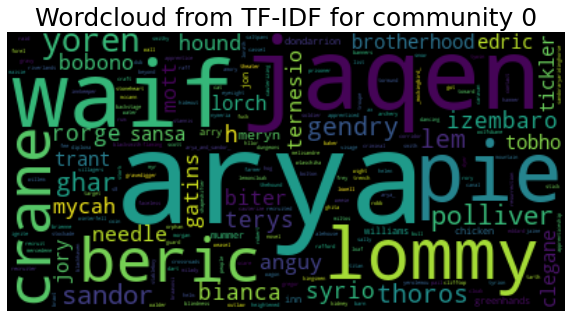

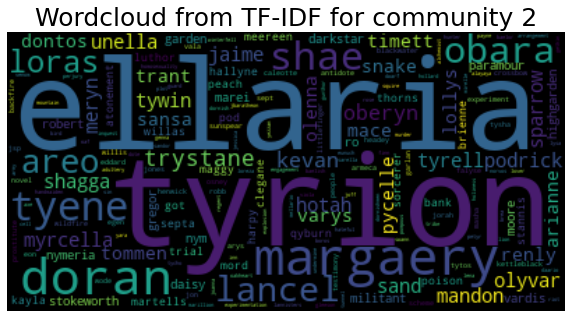

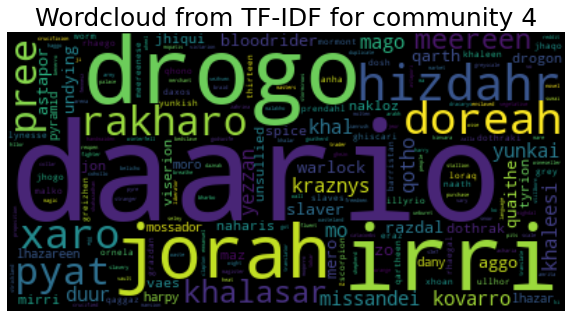

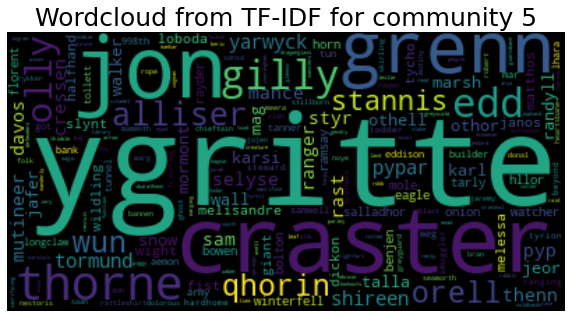

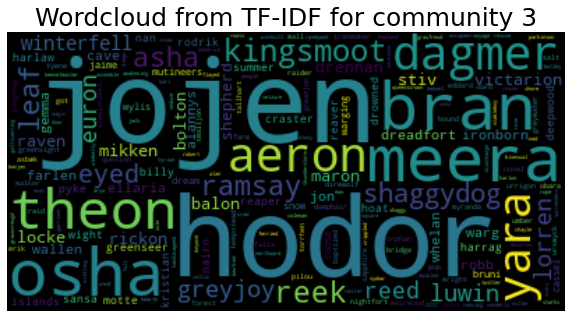

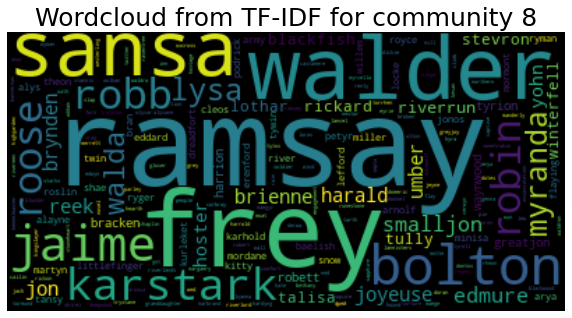

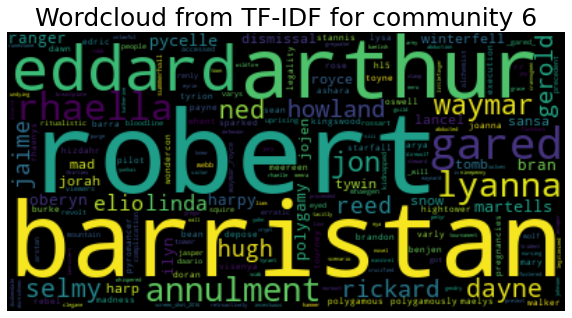

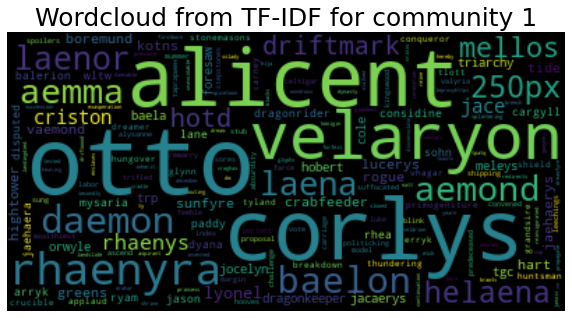

In [90]:
for com in coms_tokeep:
    wc_list = []
    # Add words to the list in proportion to their TD-IDF
    for w in list(set(com_words[com])):
        for i in range(int(10*TFIDF[com][w])):
            wc_list.append(w)
    wc = WordCloud(collocations = False).generate(' '.join(wc_list))

    plt.figure(figsize=(10,6))
    plt.title(f"Wordcloud from TF-IDF for community {com}", fontsize=25)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

## Sentiment analysis

### Per character analysis

In [91]:
## Sentiment analysis
data = pd.read_csv("dataset_S1.txt",delimiter="\t")

def sentiment(text):
    freq = dict(nltk.FreqDist(text))
    N = 0
    hav = 0
    for w in freq:
        val = data[data.word == w.lower()]
        if val.shape[0] > 0:
            hav += val.happiness_average.values[0]*freq[w]
            N += freq[w]
    return hav/N

In [92]:
sentiments = {}

re_run_sentiments_calculations = False

if re_run_sentiments_calculations:
    for char in chars_list:
        file = open(f"GoT wikis/{char}.txt", "r")
        words = re.findall(r"[\w']+",file.read())
    
        # Remove almost empty wiki pages
        if len(words) > 30:
            sentiments[char] = sentiment(words)
        
    # Save IDF dict to txtfile
    with open("sentiments.txt", "w") as file:
        for word in sentiments:
            file.write(word+";"+str(sentiments[word])+"\n")
        file.close()

else:
    with open("sentiments.txt", "r") as file:
        for line in file:
            sp = line.split(";")
            sentiments[sp[0]] = float(sp[1][:-1])
        file.close()

The mean of all the sentiments are: 5.345826191974149
The 10th and 90th percentile values for the sentiment are: 5.268024001150788 and 5.438159310456981
Sentiment standard deviation: 0.07453532624444088


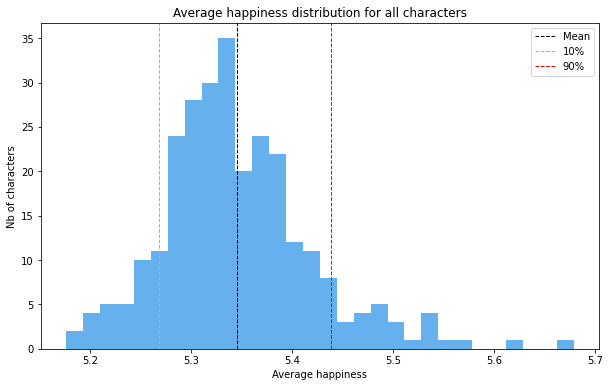

In [93]:
h_avgs = list(sentiments.values())

mean = np.mean(h_avgs)
print("The mean of all the sentiments are:",mean)

tgb = np.percentile(h_avgs, 10)
ngb = np.percentile(h_avgs, 90)
print("The 10th and 90th percentile values for the sentiment are:",tgb,"and",ngb)
print("Sentiment standard deviation:", np.std(h_avgs))

# Plot of the average happiness distribution for all characters
plt.figure(figsize=(10,6))
plt.hist(list(sentiments.values()), bins=30, color="#67B0EE")
plt.xlabel('Average happiness') 
plt.ylabel('Nb of characters')
plt.title("Average happiness distribution for all characters")
plt.axvline(mean, color='k', linestyle='dashed', linewidth=1, label="Mean")
plt.axvline(tgb, color='orange', linestyle='dashed', linewidth=1, label="10%")
plt.axvline(ngb, color='red', linestyle='dashed', linewidth=1, label="90%")
plt.legend()
plt.show()

In [94]:
# 10 happiest and 10 saddest characters
sorted_havs = {key: val for key, val in sorted(sentiments.items(), key = lambda ele: ele[1], reverse=True)}

# Number of characters to print
n_ch = 15
fmt = '  {:<20} {0:.2f}'

print(f"Top {n_ch} \"happiest\" characters :")
for ch in list(sorted_havs.keys())[:n_ch]:
    print("  {:<20}".format(ch), '{0:.3f}'.format(sorted_havs[ch]))

print(f"\nTop {n_ch} saddest characters :")
for ch in list(sorted_havs.keys())[-n_ch:]:
    print("  {:<20}".format(ch), '{0:.3f}'.format(sorted_havs[ch]))

Top 15 "happiest" characters :
  Gold Cloak           5.679
  Ryger Rivers         5.621
  Lhara                5.576
  Talla Tarly          5.551
  Handmaiden           5.543
  Child of the Forest  5.536
  Walda Bolton         5.532
  Brea                 5.530
  Roslin Tully         5.518
  Mirelle              5.510
  Melessa Tarly        5.498
  Kitty Frey           5.496
  Ternesio Terys       5.492
  Rhaenys Targaryen    5.488
  White Walker         5.485

Top 15 saddest characters :
  Lem                  5.240
  Gregor Clegane       5.239
  Lommy                5.235
  Ghost                5.231
  Grey Worm            5.227
  Othor                5.224
  Beric Dondarrion     5.223
  Yezzan zo Qaggaz     5.222
  Mandon Moore         5.220
  Wun Weg Wun Dar Wun  5.206
  Hugh                 5.203
  Amory Lorch          5.200
  Biter                5.200
  Rorge                5.180
  Polliver             5.176


### Per house sentiment analysis

In [95]:
### Per house analysis
# TF-IDF by house

houses_words = {}

# Initialize with empty list
for house in houses_list:
    houses_words[house] = []

# Go across all with-house characters
for char in houses:
    char_name = char.split("#")[0].split("/")[0]
    f = open(f'GoT wikis/{char_name}.txt')
    words = re.findall(r"\w+", f.read())[6:]
    node_name = char.split("#")[0].split("|")[0]
    houses_words[houses[node_name]] = houses_words[houses[node_name]] + words

# Lower case all the words
for house in houses_list:
    houses_words[house] = [w.lower() for w in houses_words[house]]

sentiments_houses = {}

re_run_sentiments_calculations = False

if re_run_sentiments_calculations:
    for house in houses_list:
        if len(houses_words[house]) > 30:
            sentiments_houses[house] = sentiment(houses_words[house])
        
    # Save sentiment dict to txtfile
    with open("sentiments_houses.txt", "w") as file:
        for word in sentiments_houses:
            file.write(word+";"+str(sentiments_houses[word])+"\n")
        file.close()

else:
    with open("sentiments_houses.txt", "r") as file:
        for line in file:
            sp = line.split(";")
            sentiments_houses[sp[0]] = float(sp[1][:-1])
        file.close()

The mean of all the sentiments are: 5.334053506021077
The 10th and 90th percentile values for the sentiment are: 5.26191979158641 and 5.419413847144696
Sentiment standard deviation: 0.05871499848833048


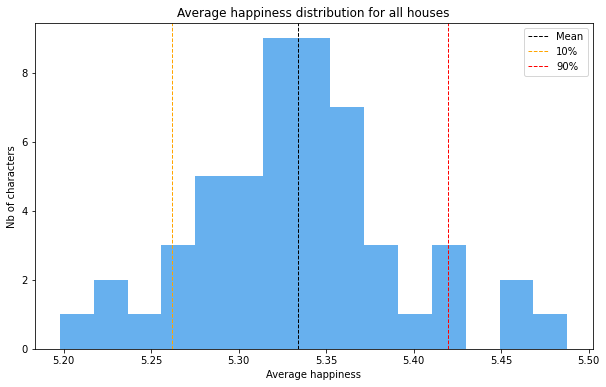

In [96]:
h_avgs = list(sentiments_houses.values())

mean = np.mean(h_avgs)
print("The mean of all the sentiments are:",mean)

tgb = np.percentile(h_avgs, 10)
ngb = np.percentile(h_avgs, 90)
print("The 10th and 90th percentile values for the sentiment are:",tgb,"and",ngb)
print("Sentiment standard deviation:", np.std(h_avgs))

# Plot of the average happiness distribution for all characters
plt.figure(figsize=(10,6))
plt.hist(list(sentiments_houses.values()), bins=15, color="#67B0EE")
plt.xlabel('Average happiness') 
plt.ylabel('Nb of characters')
plt.title("Average happiness distribution for all houses")
plt.axvline(mean, color='k', linestyle='dashed', linewidth=1, label="Mean")
plt.axvline(tgb, color='orange', linestyle='dashed', linewidth=1, label="10%")
plt.axvline(ngb, color='red', linestyle='dashed', linewidth=1, label="90%")
plt.legend()
plt.show()

In [97]:
# Sorted houses
sorted_houses = {key: val for key, val in sorted(sentiments_houses.items(), key = lambda ele: ele[1], reverse=True)}
sorted_houses

{'House Erenford': 5.487795992714022,
 'House Waynwood': 5.461451104100946,
 'House Florent': 5.45120940649496,
 'House Stokeworth': 5.4296546961325935,
 'House Frey': 5.426327798905484,
 'House Lefford': 5.421441176470587,
 'House Hunter': 5.401167883211678,
 'House Wode': 5.37954314720812,
 'House Royce': 5.378381635581061,
 'House Tyrell': 5.374313512862227,
 'House Egen': 5.370927601809951,
 'House Yarwyck': 5.366772727272722,
 'House Bracken': 5.366002066115704,
 'House Redwyne': 5.364740844196144,
 'House Strickland': 5.361366666666659,
 'House Reed': 5.358296254040688,
 'House Tarth': 5.354366958590113,
 'House Marsh': 5.351830188679245,
 'House Arryn': 5.348566096423029,
 'House Tully': 5.346887177631933,
 'House Rykker': 5.339604938271606,
 'House Glover': 5.339012987012992,
 'House Mormont': 5.338940404904476,
 'House Baelish': 5.337764304660853,
 'House Stark': 5.336193543811538,
 'House Smallwood': 5.3344184397163135,
 'House Martell': 5.332818242631733,
 'House Targaryen':

## Lexical analysis

In this part, we made many lexical dispersion plots of the top 20 high degree characters on 4 different topics : winter, war, politics and places.
Those are all important topics of the show, but the plots clearly show that they don't concern all the characters in the same way.

In [98]:
# Relevant words for different topics
winter = ["night", "winter", "white", "walker", "king", "folk", "free", "watch", "wall"]
war = ["war", "fight", "battle", "sword", "fire", "dragons", "kill"]
politics = ["alliance", "debts", "marry", "wedding", "threat", "religion", "throne", "hand", "stark", 
            "lannister", "targaryen", "realm", "iron", "rule", "duty"]
places = ["westeros", "north", "winterfell", "braavos", "pentos", "myr", "lanidng", "meereen", "qarth", "dothrak"]

# Relevant characters
characters_of_interest = ["Tyrion Lannister", "Jon Snow", "Daenerys Targaryen", "Arya Stark", "Sansa Stark",
                          "Eddard Stark", "Jaime Lannister", "Cersei Lannister", "Robb Stark", "Bran Stark",
                          "Robert Baratheon", "Catelyn Stark", "Stannis Baratheon", "Tywin Lannister",
                          "Joffrey Baratheon", "Petyr Baelish", "Varys", "Theon Greyjoy", "Samwell Tarly",
                          "Davos Seaworth"]

### Winter

Winter words dispersion plots for top 20 characters

Tyrion Lannister


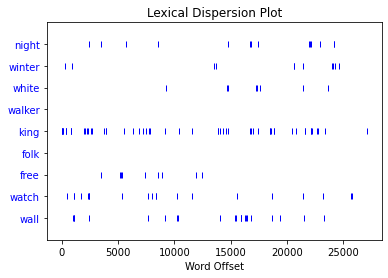

Jon Snow


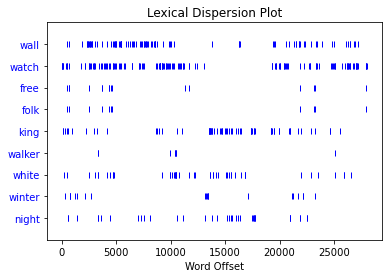

Daenerys Targaryen


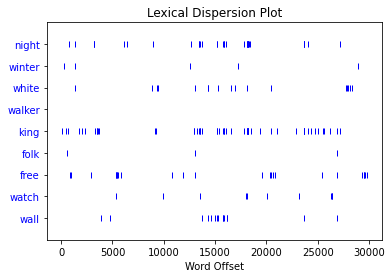

Arya Stark


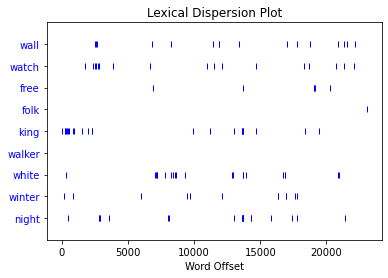

Sansa Stark


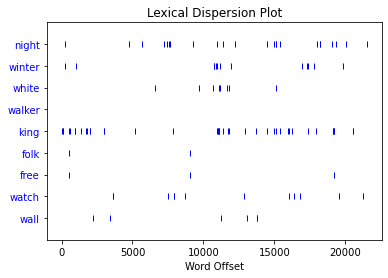

Eddard Stark


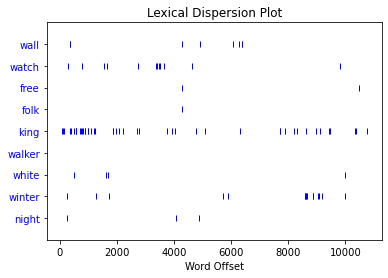

Jaime Lannister


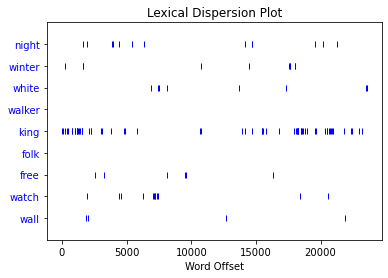

Cersei Lannister


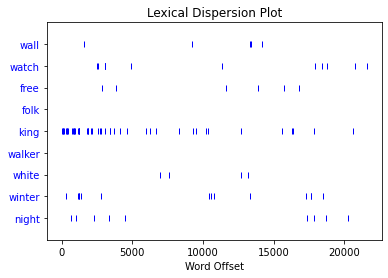

Robb Stark


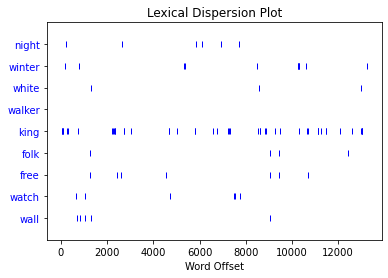

Bran Stark


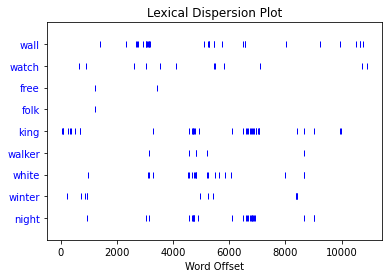

Robert Baratheon


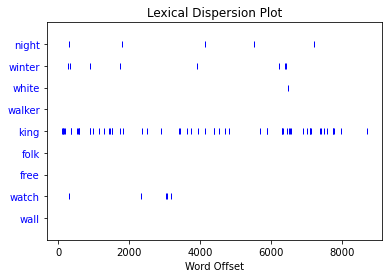

Catelyn Stark


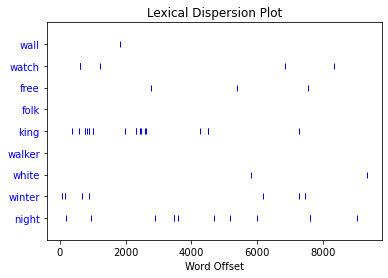

Stannis Baratheon


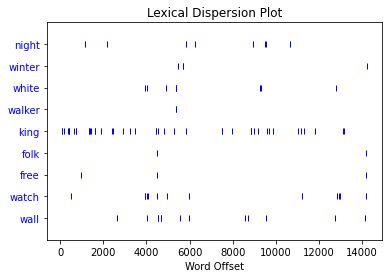

Tywin Lannister


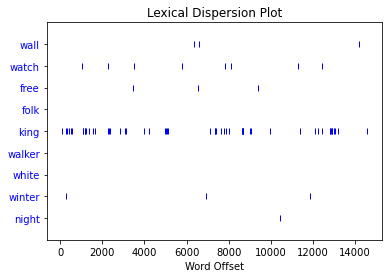

Joffrey Baratheon


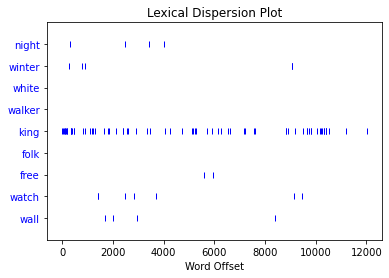

Petyr Baelish


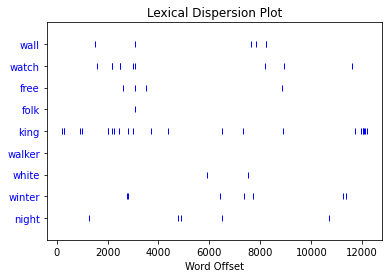

Varys


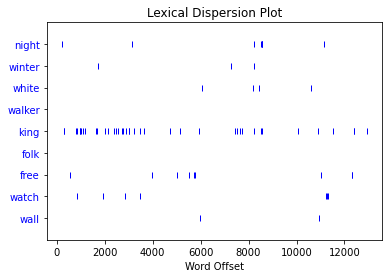

Theon Greyjoy


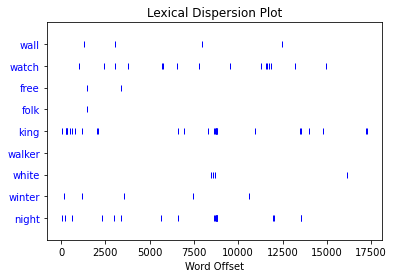

Samwell Tarly


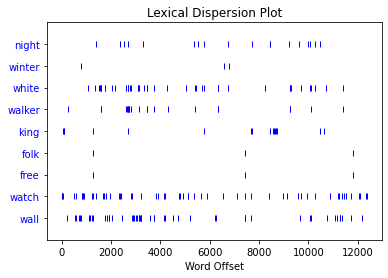

Davos Seaworth


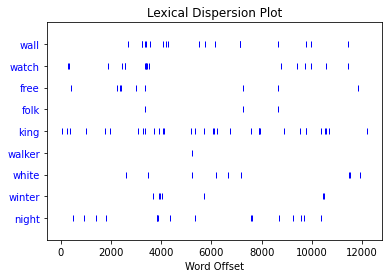

In [99]:
# Lexical dispersion plot of words related to winter
print("Winter words dispersion plots for top 20 characters\n")
for char in characters_of_interest:
    print(char)
    f = open(f"GoT wikis/{char}.txt", "r")
    text = re.findall(r"[\w']+", f.read())
    text = [w.lower() for w in text]
    f.close()
    dispersion_plot(text, winter)

### War

War words dispersion plots for top 20 characters

Tyrion Lannister


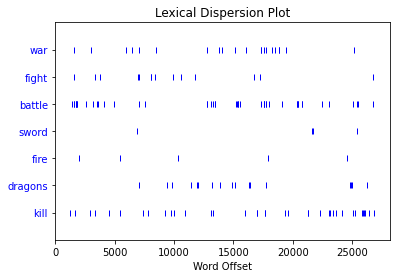

Jon Snow


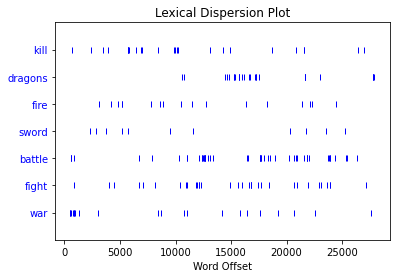

Daenerys Targaryen


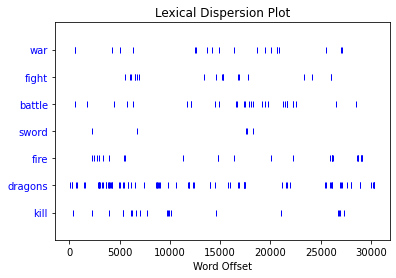

Arya Stark


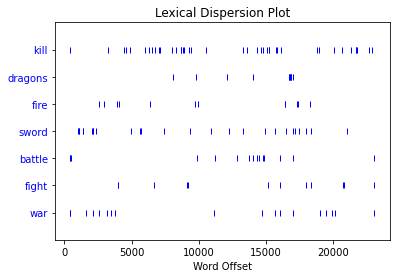

Sansa Stark


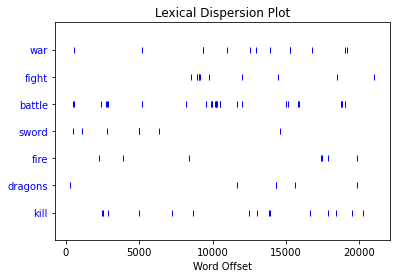

Eddard Stark


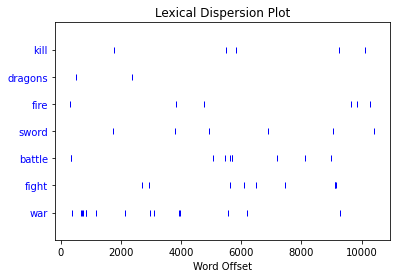

Jaime Lannister


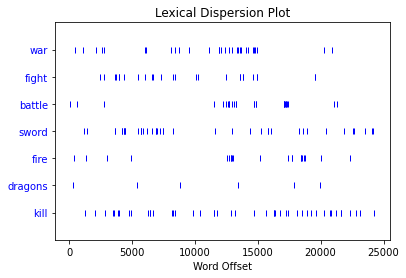

Cersei Lannister


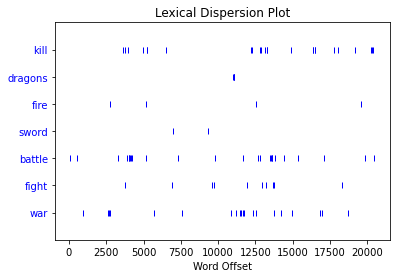

Robb Stark


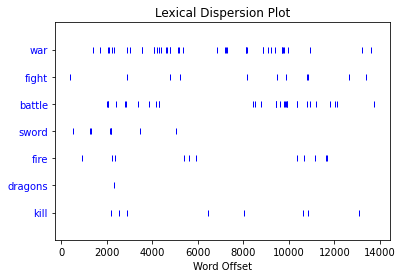

Bran Stark


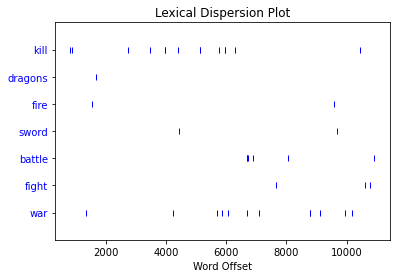

Robert Baratheon


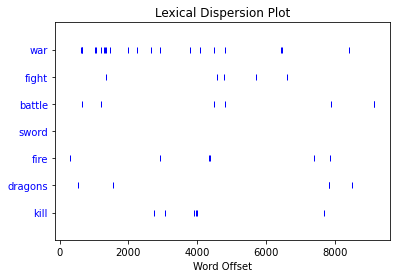

Catelyn Stark


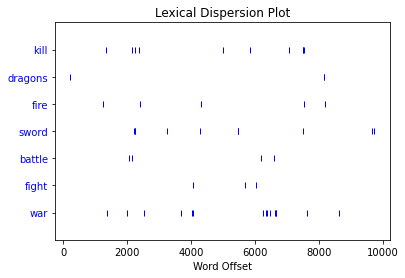

Stannis Baratheon


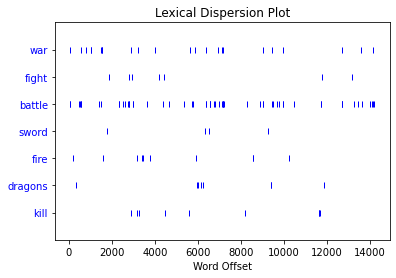

Tywin Lannister


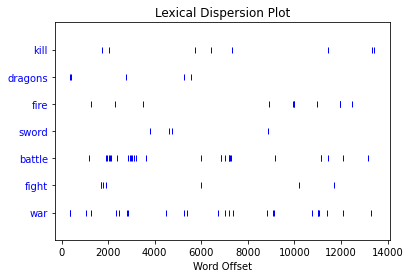

Joffrey Baratheon


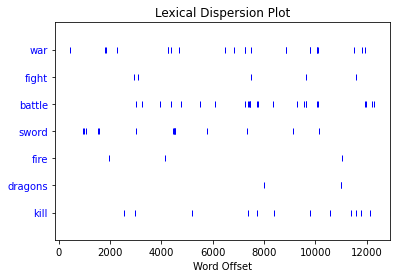

Petyr Baelish


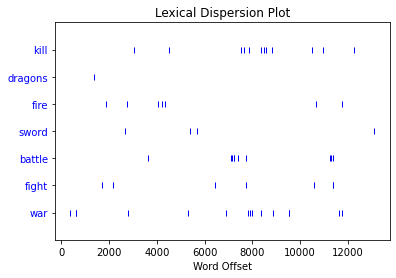

Varys


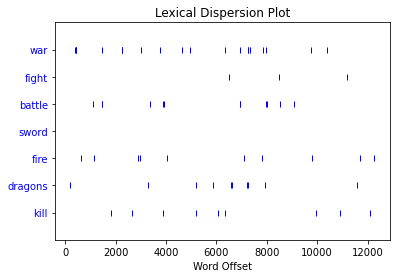

Theon Greyjoy


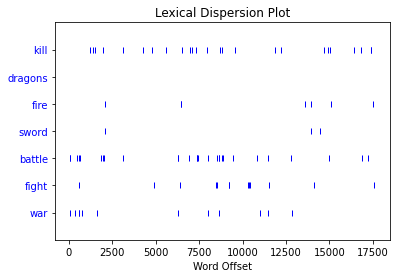

Samwell Tarly


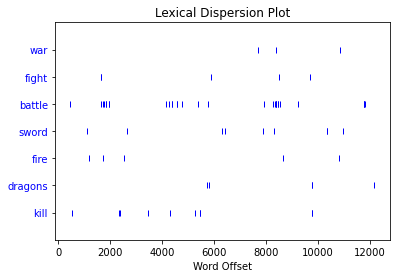

Davos Seaworth


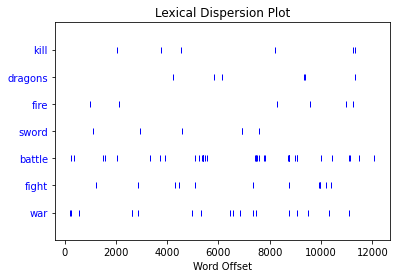

In [100]:
# Lexical dispersion plot of words related to war
print("War words dispersion plots for top 20 characters\n")
for char in characters_of_interest:
    print(char)
    f = open(f"GoT wikis/{char}.txt", "r")
    text = re.findall(r"[\w']+", f.read())
    text = [w.lower() for w in text]
    f.close()
    dispersion_plot(text, war)

### Politics

Politics words dispersion plots for top 20 characters

Tyrion Lannister


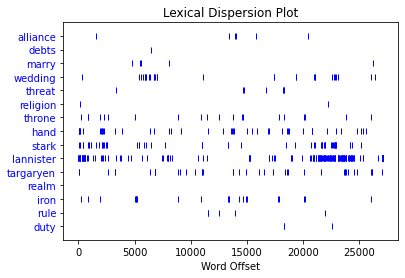

Jon Snow


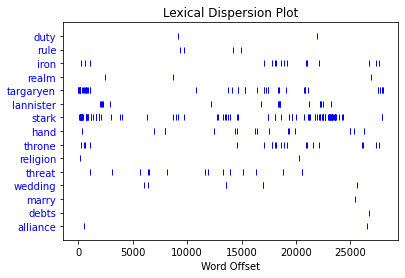

Daenerys Targaryen


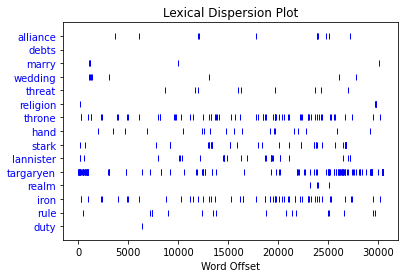

Arya Stark


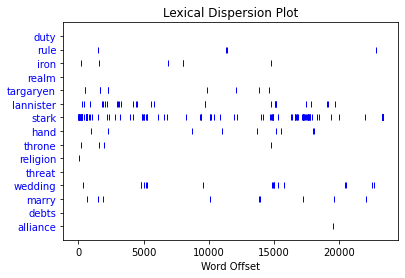

Sansa Stark


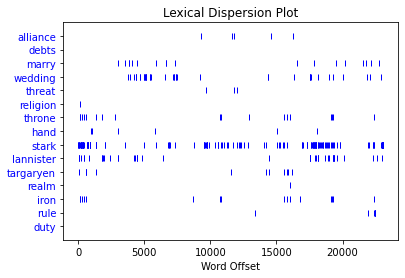

Eddard Stark


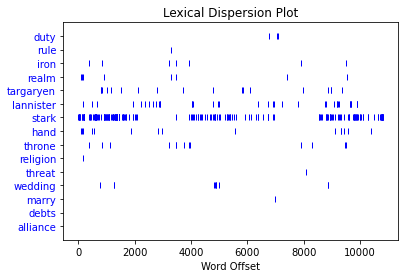

Jaime Lannister


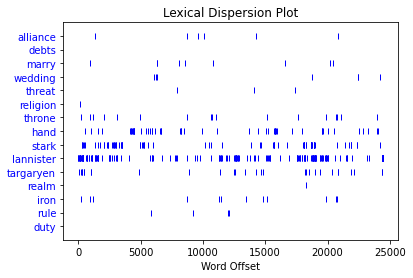

Cersei Lannister


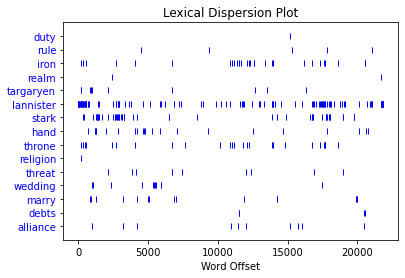

Robb Stark


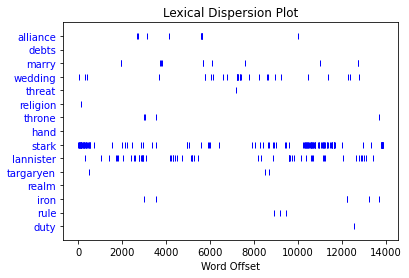

Bran Stark


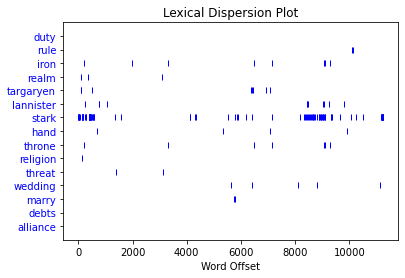

Robert Baratheon


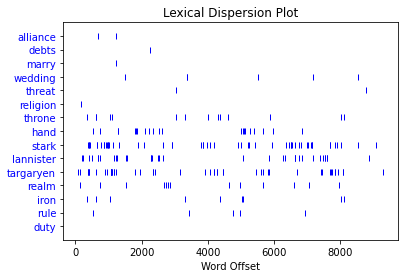

Catelyn Stark


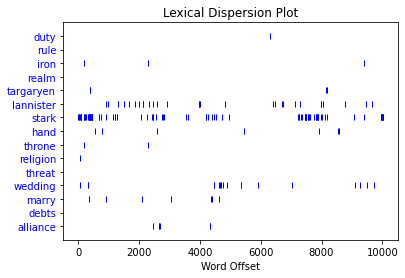

Stannis Baratheon


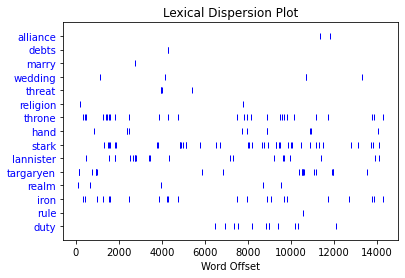

Tywin Lannister


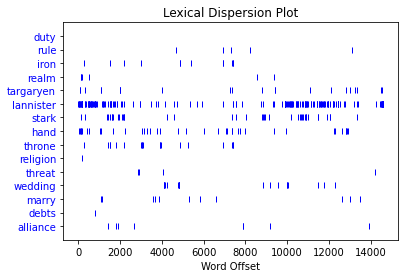

Joffrey Baratheon


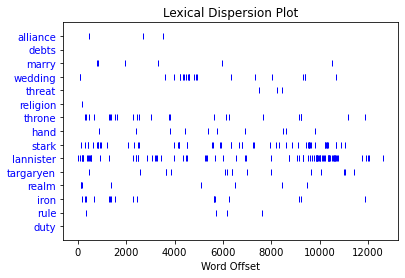

Petyr Baelish


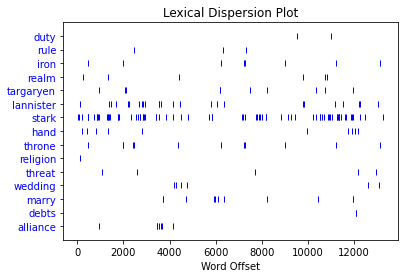

Varys


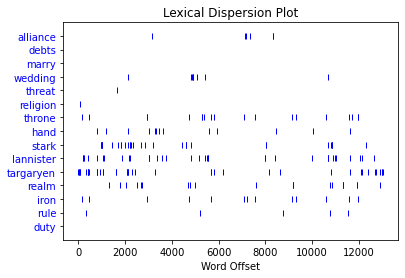

Theon Greyjoy


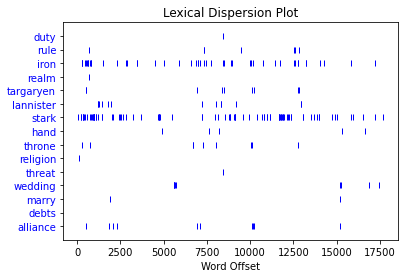

Samwell Tarly


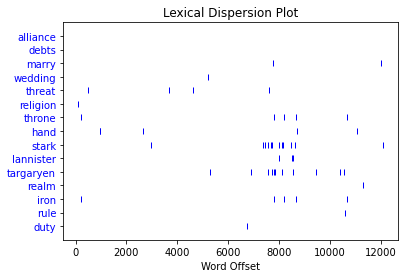

Davos Seaworth


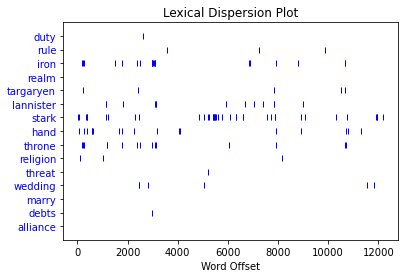

In [101]:
# Lexical dispersion plot of words related to politics
print("Politics words dispersion plots for top 20 characters\n")
for char in characters_of_interest:
    print(char)
    f = open(f"GoT wikis/{char}.txt", "r")
    text = re.findall(r"[\w']+", f.read())
    text = [w.lower() for w in text]
    f.close()
    dispersion_plot(text, politics)

### Places

Location words dispersion plots for top 20 characters

Tyrion Lannister


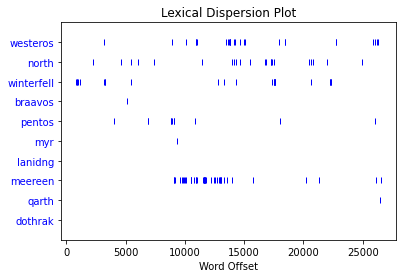

Jon Snow


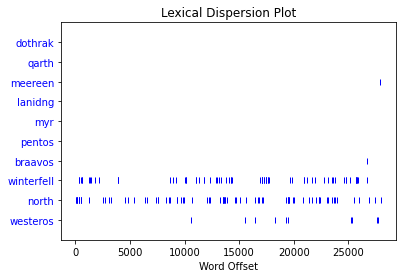

Daenerys Targaryen


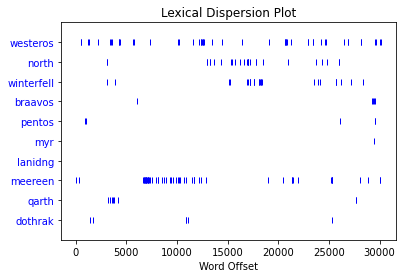

Arya Stark


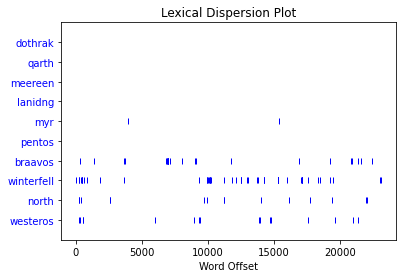

Sansa Stark


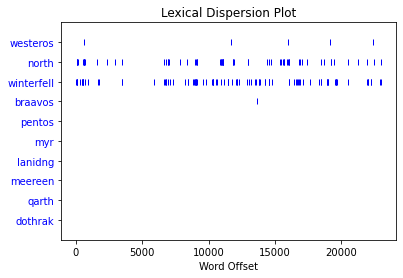

Eddard Stark


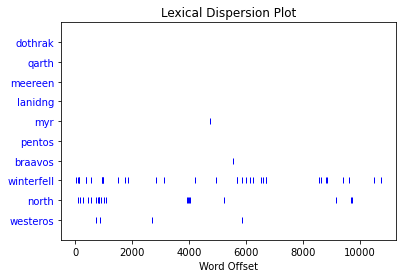

Jaime Lannister


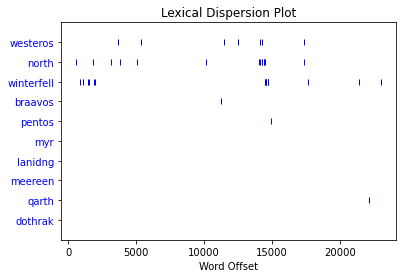

Cersei Lannister


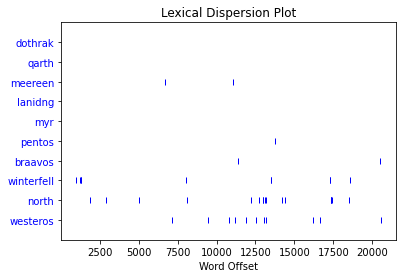

Robb Stark


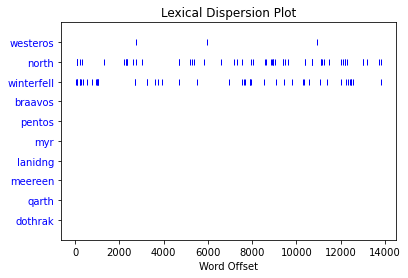

Bran Stark


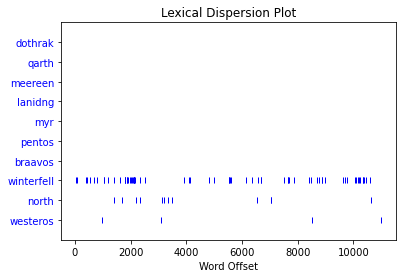

Robert Baratheon


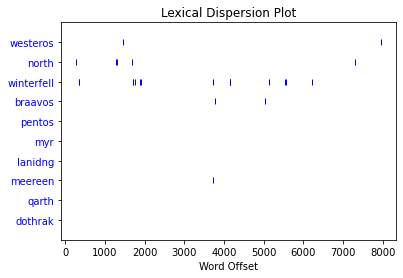

Catelyn Stark


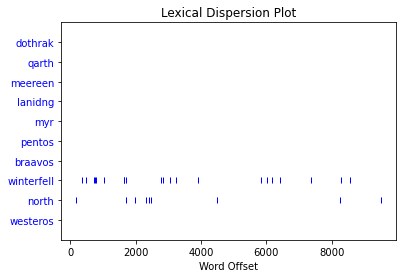

Stannis Baratheon


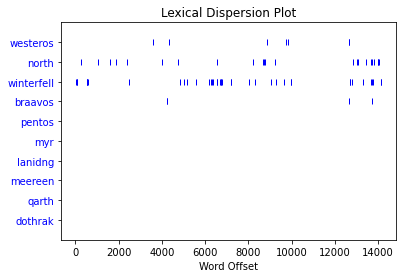

Tywin Lannister


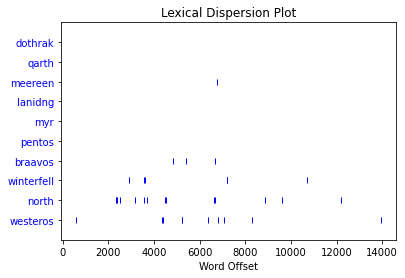

Joffrey Baratheon


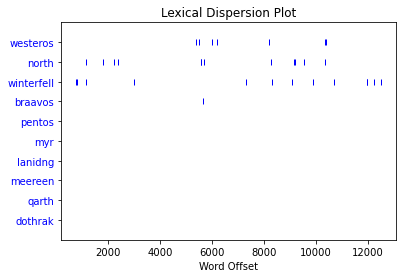

Petyr Baelish


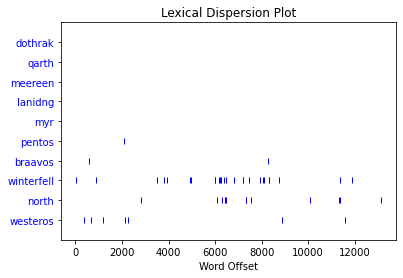

Varys


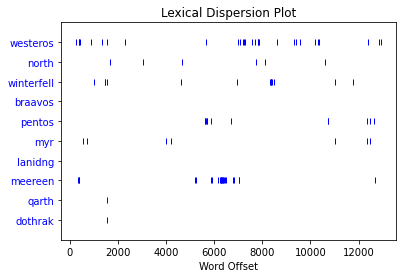

Theon Greyjoy


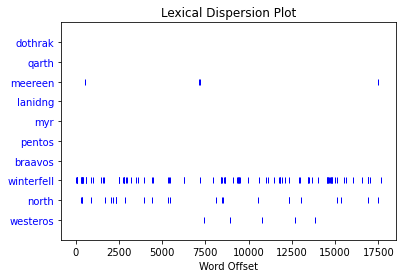

Samwell Tarly


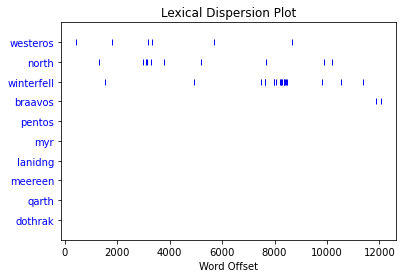

Davos Seaworth


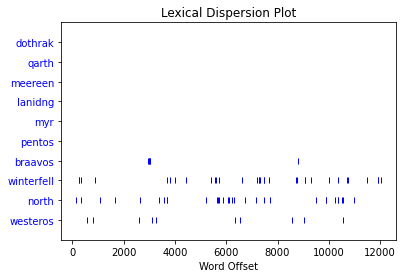

In [102]:
# Lexical dispersion plot of words related to places
print("Location words dispersion plots for top 20 characters\n")
for char in characters_of_interest:
    print(char)
    f = open(f"GoT wikis/{char}.txt", "r")
    text = re.findall(r"[\w']+", f.read())
    text = [w.lower() for w in text]
    f.close()
    dispersion_plot(text, places)

## Death Social Graph analysis

In [103]:
baseurl = " http://gameofthrones.wikia.com/api.php?"
action = "action=query"
name = "Game_of_Thrones_starring_cast_appearances"
#name = name.replace('-','_')
#name = name.replace(' ','_')
title = f"titles={name}"
content = "prop=revisions&rvprop=content"
dataformat ="format=json"

query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)

wikiresponse = urllib.request.urlopen(query)
wikidata = wikiresponse.read()
charsp = wikidata.decode('utf-8')
chars_json = json.loads(charsp)['query']['pages']#[list(ned_json.keys())[0]]

chars_json = chars_json[list(chars_json.keys())[0]]["revisions"][0]["*"]
chars_json

chars = re.findall(r'as \[\[([\w\s\(\)-._@\',#:"!&=\\]+)[\|\]\]]', chars_json)
chars = list(set(chars))

In [104]:
# Create a dictionnary that will take as key the name of the victim and as values the name of the killers
chars_list.append("wight") # Add this character manually to the list of characters
killedBy = {}

for char in chars_list:
    if char != "wight": # Make an exception for this character as no wiki page will correspond to it
        text = open(f"Got wikis/{char}.txt", encoding="utf8").read()
        if re.findall('(?<=Status      =)[^]]*',text) != [' [[:Category:Living individuals|Alive']: #Ensure that character is dead
            deathRegEx = re.findall('(?<=Death       =)[^=]*', text)
            if deathRegEx != ['  | Allegiance  '] and len(deathRegEx) > 0:
                deathKeyWords = re.findall(r'\[\[([\w\s\)-._\']+)[\|\]\]]', deathRegEx[0])
                assassins = []
                for word in deathKeyWords:
                    if word in chars_list:
                        assassins.append(word)
                killedBy[char] = assassins

In [105]:
list1 = [x for x in list(killedBy.values()) if x]
list1 = [item for sublist in list1 for item in sublist]

list_values = list(set(list1))
list_keys = list(killedBy.keys())

nodes_death = list(set(list_values + list_keys))

In [106]:
G_death = nx.DiGraph()
G_death.add_nodes_from(nodes_death)

edges = []
for character in killedBy:
    for killer in killedBy[character]:
        edges.append((killer,character))
G_death.add_edges_from(edges)

In [107]:
nodes_sizes_death = list(dict(G_death.degree()).values())
nodes_sizes_death = [10*ns for ns in nodes_sizes_death]

In [108]:
outDegree = dict(G_death.out_degree(nodes_death))
top10Killers = sorted(outDegree, key=outDegree.get, reverse=True)[:10]

top10dict = {}
for killer in top10Killers:
    top10dict[killer] = killer

100%|██████████████████████████████████████| 2000/2000 [00:02<00:00, 923.97it/s]


BarnesHut Approximation  took  0.77  seconds
Repulsion forces  took  1.12  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.10  seconds


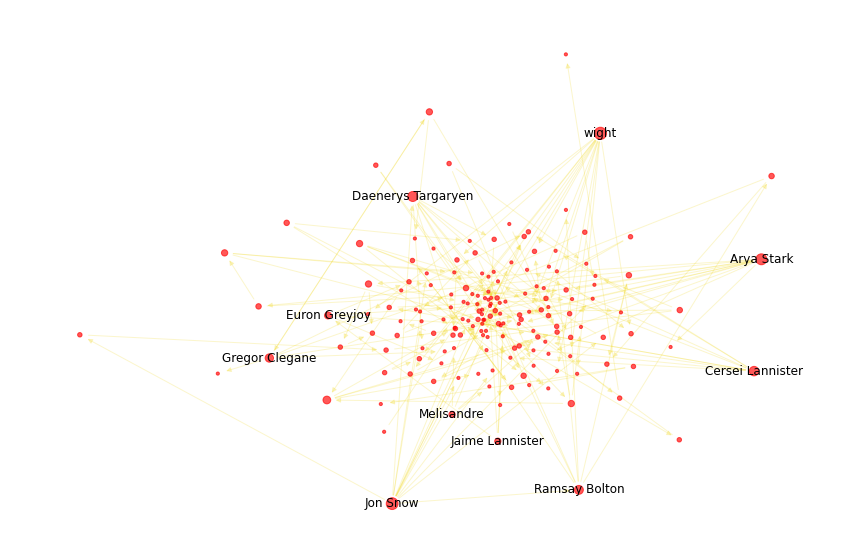

In [109]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=100.0,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G_death, pos=None, iterations=2000)

plt.figure(figsize=(15,10))
nx.draw_networkx_nodes(G_death, positions, node_size=nodes_sizes_death, node_color='#FF0000', alpha=0.65)
nx.draw_networkx_edges(G_death, positions, edge_color="#EED200", alpha=0.2)
nx.draw_networkx_labels(G_death, positions, labels= top10dict)
plt.axis('off')
plt.show()

In [110]:
Nb_kills = dict(G_death.out_degree(nodes_death))

### Correlation between number of kills and number of neighbour nodes

In [111]:
#Build the dataframe:
df_centrality = pd.DataFrame(list(dict(G.degree()).items()), columns = ['Character', 'Number of links'])
df_killers = pd.DataFrame(list(Nb_kills.items()), columns = ['Character', 'Number of kills'])

df_final = pd.merge(df_centrality, df_killers, how = "outer", on = ["Character", "Character"])
df_final = df_final.fillna(0)

df_final[df_final["Character"]=="Wight"]["Number of kills"] = df_final[df_final["Character"]=="wight"]["Number of kills"]

df_final = df_final[:-1]

In [112]:
df_final[["Number of links","Number of kills"]].corr()

Number of links  Number of kills
Number of links         1.000000         0.651387
Number of kills         0.651387         1.000000

## Per season analysis

In [ ]:
# Store parts of the wikis of chars that concerns each season

'''
for char in chars_list:
    f = open(f"GoT wikis/{char}.txt", "r")
    text = f.read()
    text = text.split("''Game of Thrones'': Season")
    if len(text) > 1:
        text.pop(0)

        last = text.pop()
        last = last.split("==")

        for txt in text:
            seas = int(txt[1])
            my_txt = re.sub("File:.*?\|thumb\|","",txt)
            with open(f"Season {seas}/{char}.txt", "w") as file:
                file.write(my_txt)
            file.close()

        last_seas = int(last[0][1])
        my_last = re.sub("File:.*?\|thumb\|","",last[1])
        with open(f"Season {last_seas}/{char}.txt", "w") as file:
            file.write(my_last)
        file.close()

    f.close()
'''

In [113]:
seasons_G = []
n_nodes = []
n_edges = []

for s in range(1,9):

    # Make graph out of it
    GS = nx.DiGraph()

    # Dictionnaries with nodes attributes
    lengths = {}
    words = {}

    # List of all characters for whom we downloaded the wiki page
    chars_list_s = os.listdir(f"Season {s}")
    chars_list_s.remove(".DS_Store")
    chars_list_s = [char[:-4] for char in chars_list_s]
    for char in chars_list_s:
        GS.add_node(char)
        file = open(f"Season {s}/{char}.txt", "r")
        neighbours = find_links(file.read())
        file.close()
    
        lengths[char] = len(neighbours)
        counts = Counter(neighbours)
    
        for nb in counts:
            GS.add_edge(char, nb, weight=counts[nb])  # Add edges with strength attributes

    for char in chars_list_s:
        f = open(f"Season {s}/{char}.txt", "r")
        words_list = re.findall(r"[\w']+", f.read())
        f.close()
        words[char] = len(words_list)

    nx.set_node_attributes(GS, lengths, "length")
    nx.set_node_attributes(GS, words, "words")
        
    print(f"Number of nodes, season {s} : {len(list(GS.nodes()))}")
    print(f"Number of edges, season {s} : {len(list(GS.edges()))}\n")
    
    n_nodes.append(len(list(GS.nodes())))
    n_edges.append(len(list(GS.edges())))
    
    houses_s = {}

    for char in chars_list_s:
        f = open(f"GoT wikis/{char}.txt")
        h = re.findall(r'Allegiance  = \[\[([\w\s\)-._\'/]+)[\|\]\]]', f.read())    
        f.close()
        if len(h) > 0 and h[0][:5] == "House":
            house = h[0].split(" of")[0]
            house = house.split("/")[0]
            houses_s[char] = house
        else:
            f = open(f"Got wikis/{char}.txt")
            h = re.findall(r'Allegiance=\[\[([\w\s\)-._\']+)[\|\]\]]', f.read())
            f.close()
            if len(h) > 0 and h[0][:5] == "House":
                house = h[0].split(" of")[0]
                house = house.split("/")[0]
                houses_s[char] = house

    nx.set_node_attributes(GS, houses_s, "house")
    
    seasons_G.append(GS)

Number of nodes, season 1 : 141
Number of edges, season 1 : 1035

Number of nodes, season 2 : 132
Number of edges, season 2 : 785

Number of nodes, season 3 : 127
Number of edges, season 3 : 657

Number of nodes, season 4 : 136
Number of edges, season 4 : 567

Number of nodes, season 5 : 119
Number of edges, season 5 : 480

Number of nodes, season 6 : 147
Number of edges, season 6 : 600

Number of nodes, season 7 : 112
Number of edges, season 7 : 494

Number of nodes, season 8 : 80
Number of edges, season 8 : 252



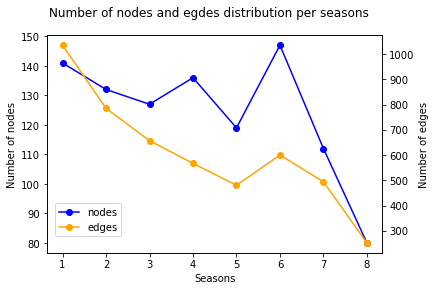

In [114]:
x = range(1,9) 

fig, ax1 = plt.subplots() 
fig.suptitle("Number of nodes and egdes distribution per seasons")
  
ax1.set_xlabel('Seasons') 
ax1.set_ylabel('Number of nodes') 
ax1.plot(x, n_nodes, 'o-', color="blue", label="nodes")
#ax1.legend()

ax2 = ax1.twinx() 
ax2.set_ylabel('Number of edges') 
ax2.plot(x, n_edges, 'o-', color = 'orange', label="edges")

fig.legend(loc='lower left',borderaxespad=5.5)
plt.show()

100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1664.66it/s]


BarnesHut Approximation  took  0.27  seconds
Repulsion forces  took  0.71  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.08  seconds


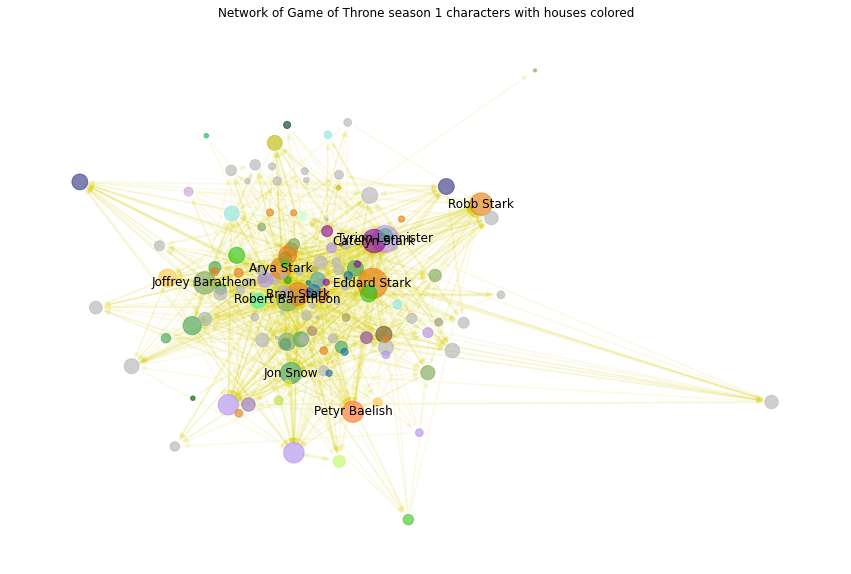

100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1803.92it/s]


BarnesHut Approximation  took  0.25  seconds
Repulsion forces  took  0.65  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.08  seconds


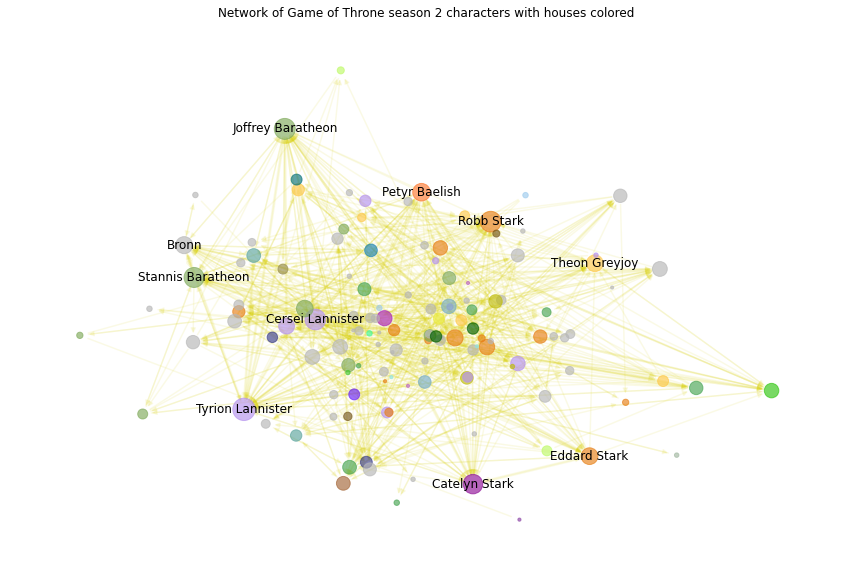

100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1931.18it/s]


BarnesHut Approximation  took  0.23  seconds
Repulsion forces  took  0.60  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.07  seconds


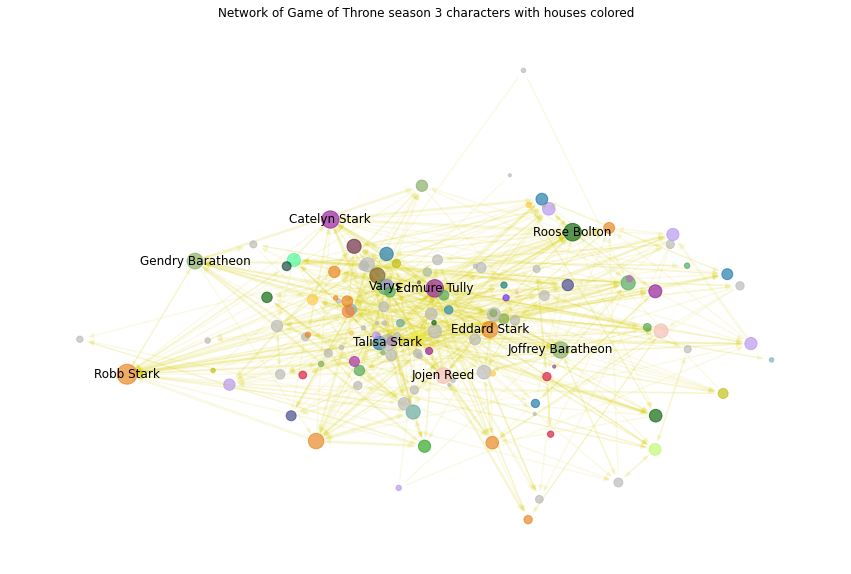

100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1694.48it/s]


BarnesHut Approximation  took  0.26  seconds
Repulsion forces  took  0.70  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.08  seconds


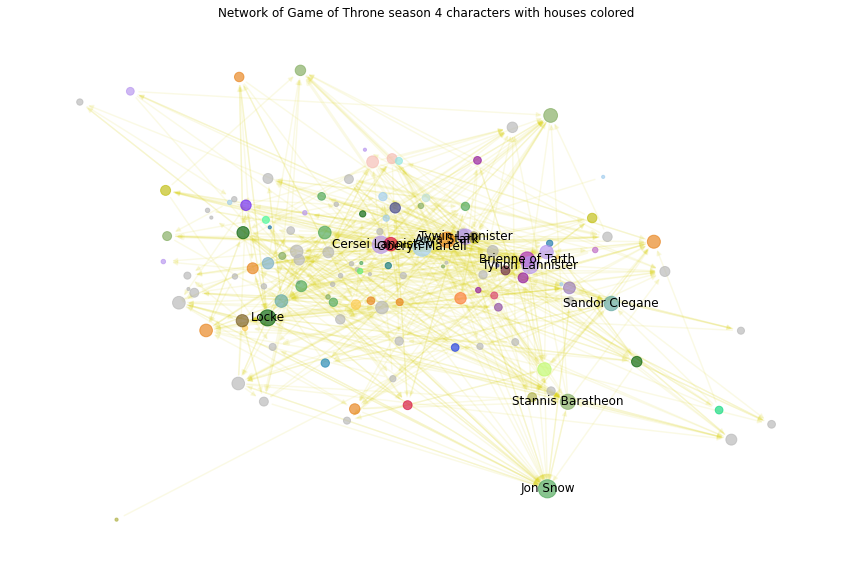

100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1915.98it/s]


BarnesHut Approximation  took  0.24  seconds
Repulsion forces  took  0.60  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.07  seconds


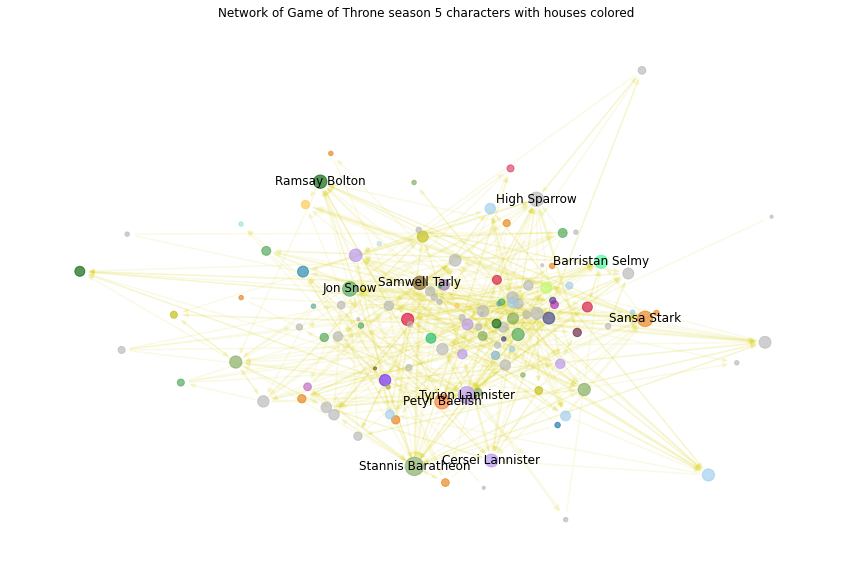

100%|█████████████████████████████████████| 2000/2000 [00:01<00:00, 1488.51it/s]


BarnesHut Approximation  took  0.30  seconds
Repulsion forces  took  0.81  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.09  seconds


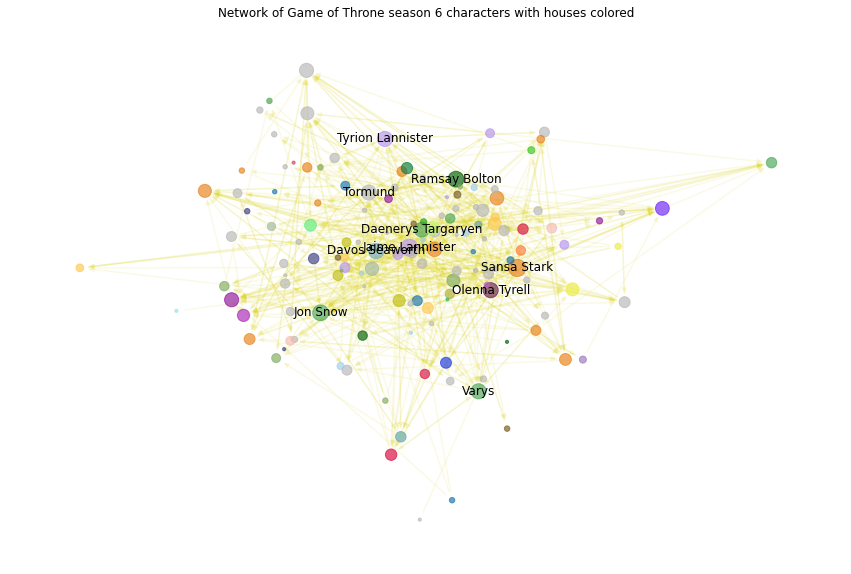

100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 2220.39it/s]


BarnesHut Approximation  took  0.21  seconds
Repulsion forces  took  0.52  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.06  seconds


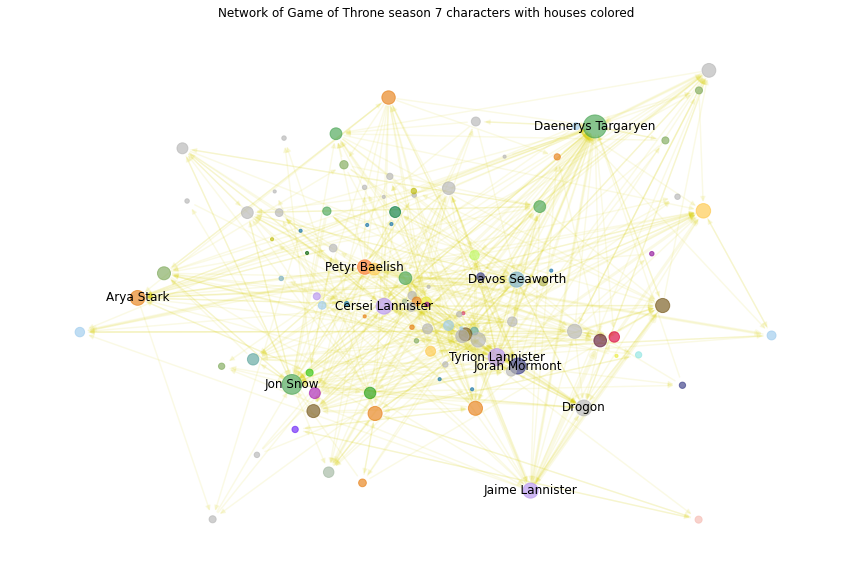

100%|█████████████████████████████████████| 2000/2000 [00:00<00:00, 3549.33it/s]


BarnesHut Approximation  took  0.14  seconds
Repulsion forces  took  0.30  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.05  seconds


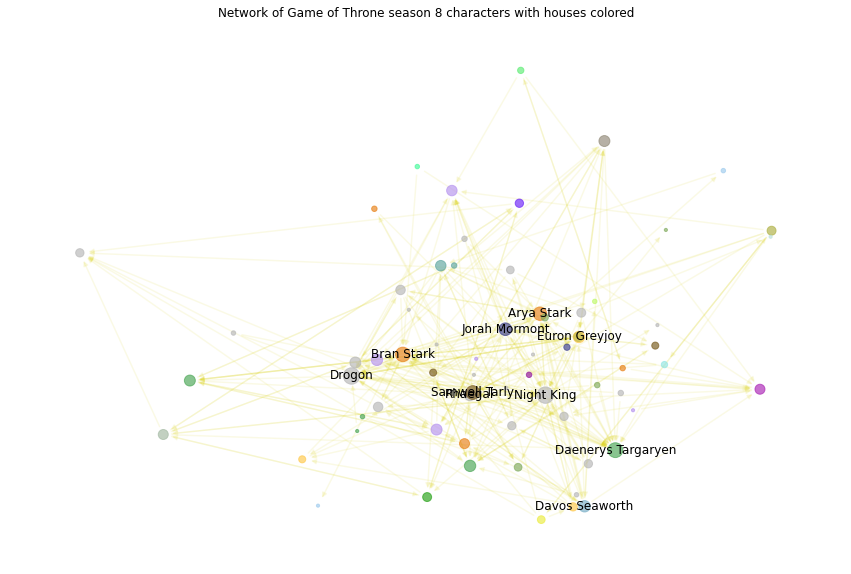

In [119]:
# Displayy the 8 graphs of the seasons

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=250.0,

                        # Log
                        verbose=True)

chars_without_house.append("wight")

for (s, GS) in enumerate(seasons_G):
    
    # Set colors to each node
    random_nodes_colors = []
    for node in GS.nodes():
        if node in chars_without_house:
            random_nodes_colors.append("#b6b6b6")
        else:
            random_nodes_colors.append(houses_colors[houses[node]])

    # Define nodes sizes
    nodes_sizes = list(dict(GS.degree()).values())
    nodes_sizes = [10*ns for ns in nodes_sizes]

    # Define edges width
    edges_weights = list(nx.get_edge_attributes(GS, "weight").values())
    edges_weights = [ew*1.5 for ew in edges_weights]
    
    top_10_glob = list({key: val for key, val in sorted(dict(GS.degree()).items(), key = lambda ele: ele[1], reverse=True)})[:10]
    labels_s = {}
    for charact in top_10_glob:
        labels_s[charact] = charact

    positions = forceatlas2.forceatlas2_networkx_layout(GS, pos=None, iterations=2000)

    plt.figure(figsize=(15,10))
    plt.title(f"Network of Game of Throne season {s+1} characters with houses colored")
    nx.draw_networkx_nodes(GS, positions, node_size=nodes_sizes, node_color=random_nodes_colors, alpha=0.65)
    nx.draw_networkx_edges(GS, positions, edge_color="#D5CC00", width=edges_weights, alpha=0.1)
    nx.draw_networkx_labels(GS, positions, labels=labels_s)
    plt.axis('off')
    plt.show()

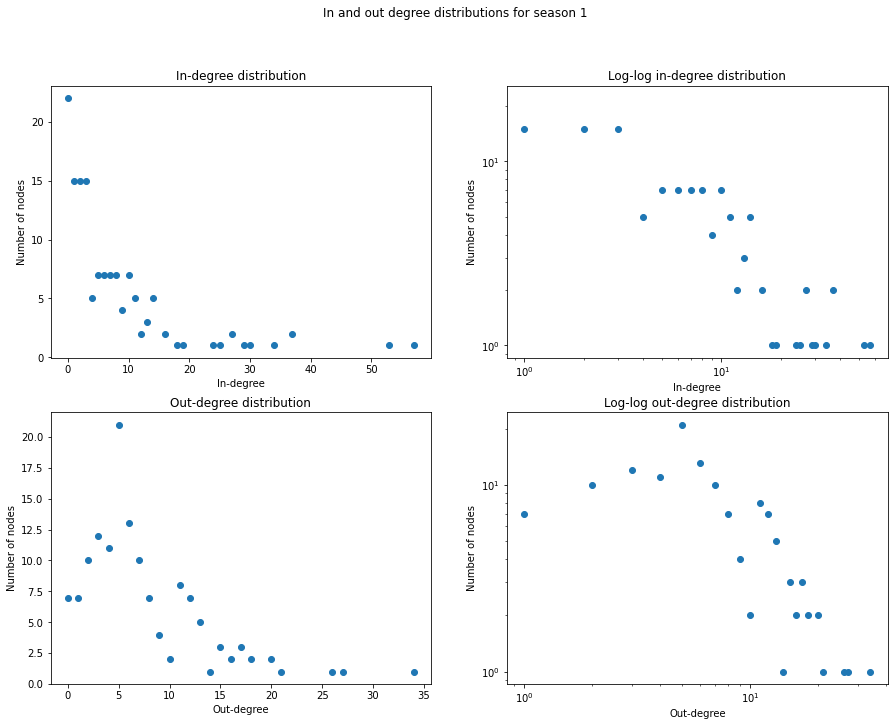

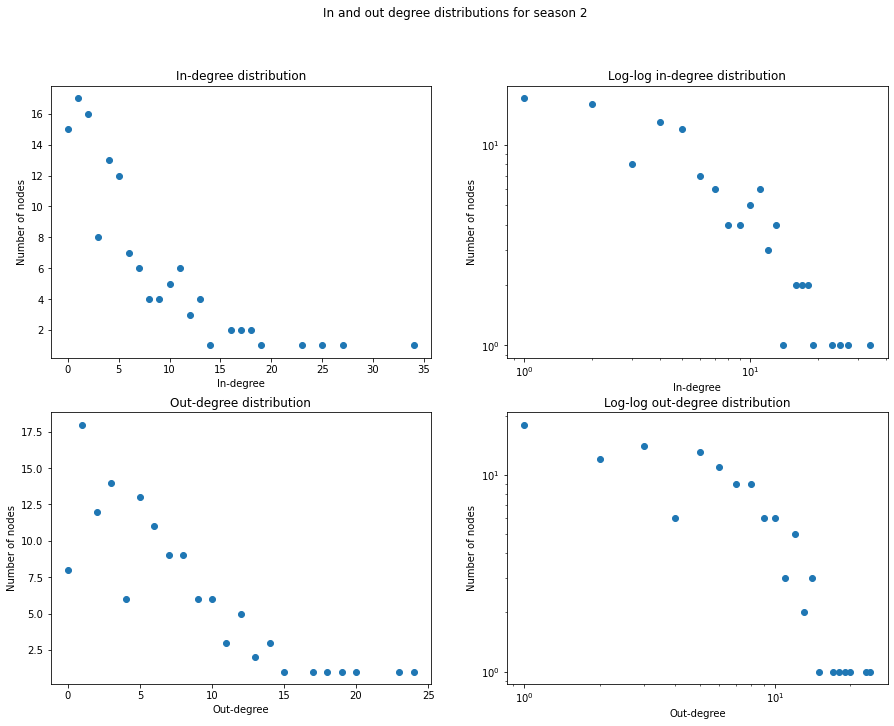

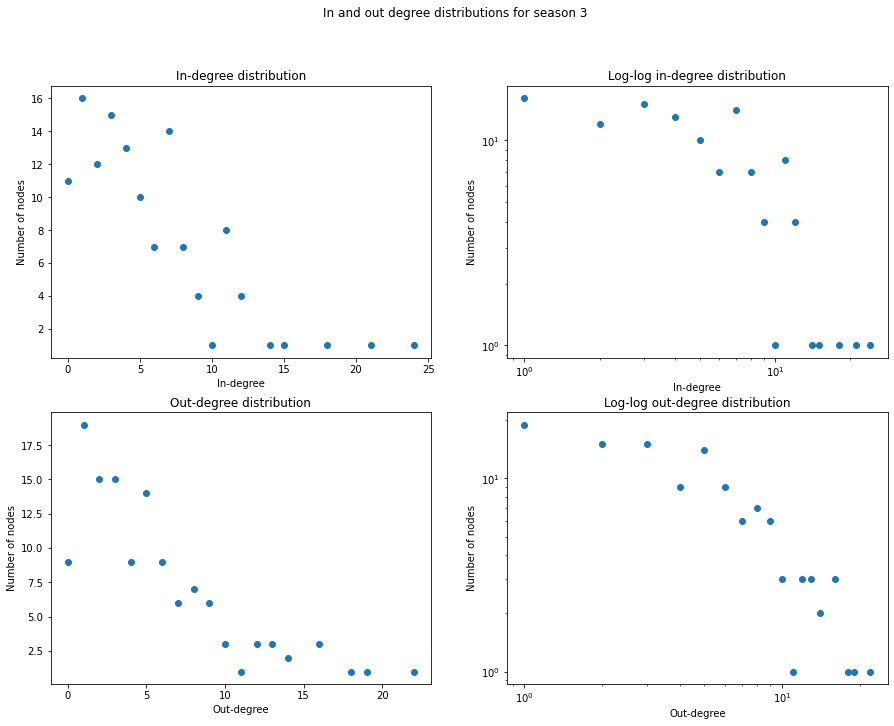

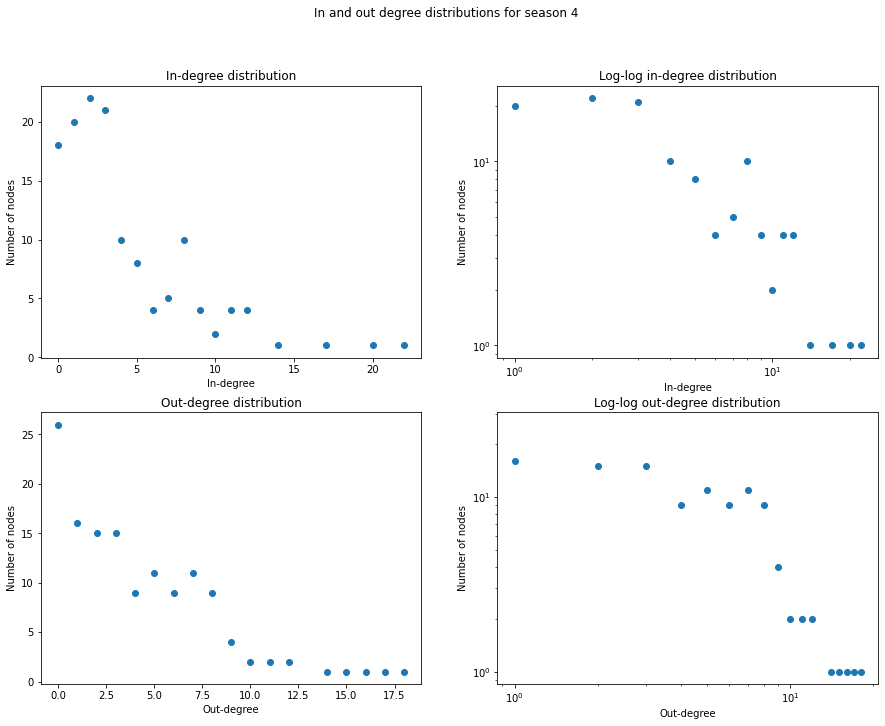

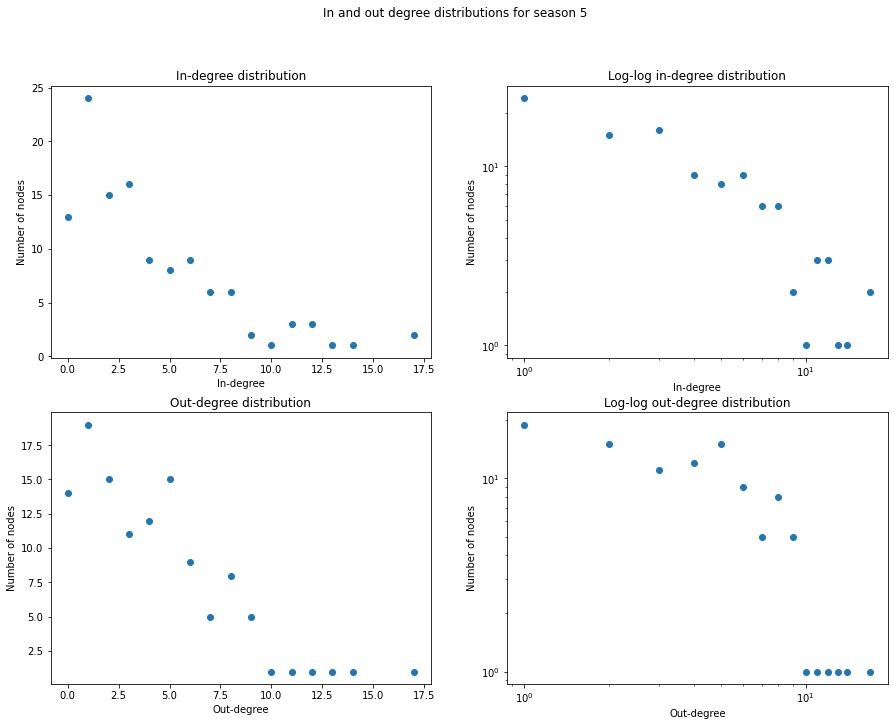

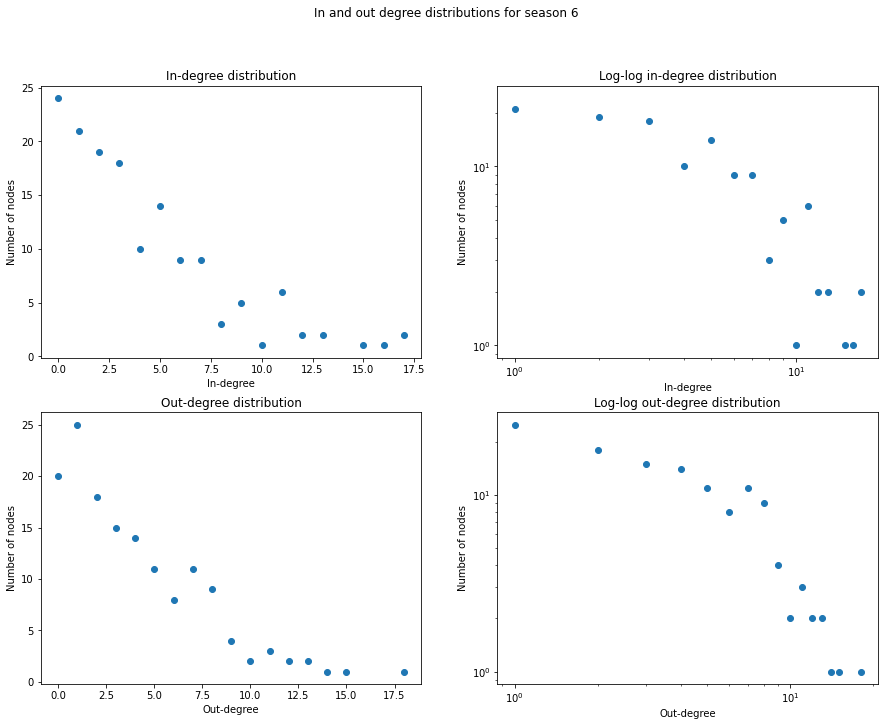

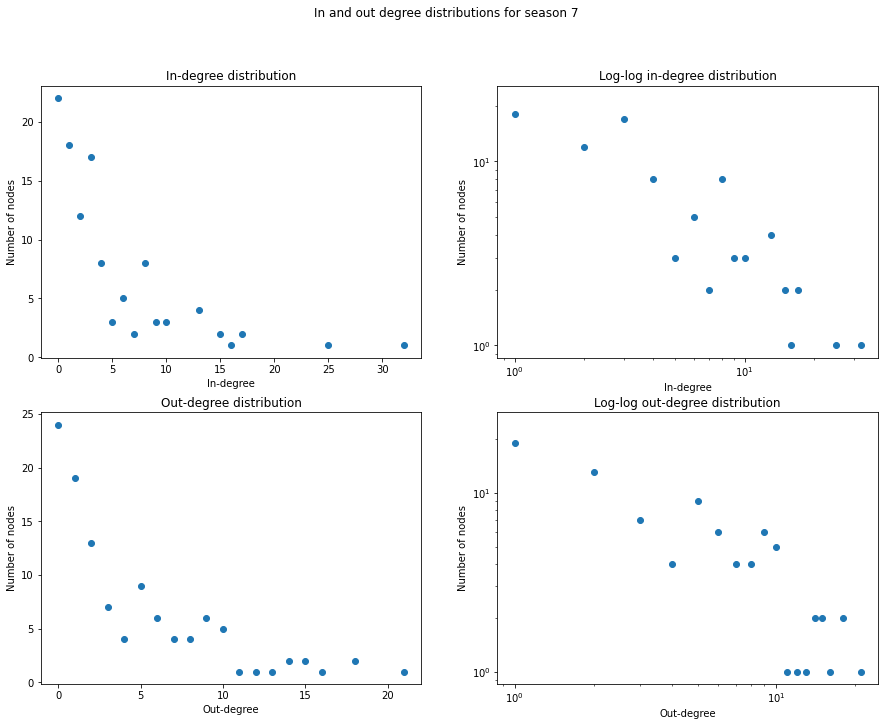

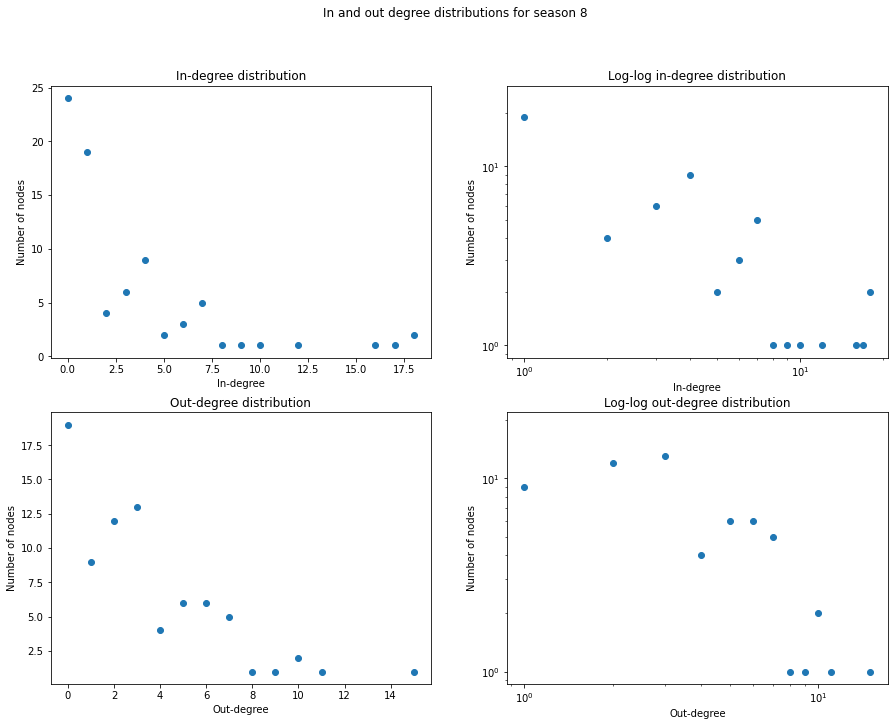

In [117]:
for s,GS in enumerate(seasons_G):
    in_degs = list(dict(GS.in_degree()).values())
    out_degs = list(dict(GS.out_degree()).values())

    count_in = Counter(in_degs)
    count_out = Counter(out_degs)

    fig, axs = plt.subplots(2, 2, figsize=(15,11))
    fig.suptitle(f"In and out degree distributions for season {s+1}")

    axs[0,0].plot(list(count_in.keys()), list(count_in.values()), 'o')
    axs[0,0].set_ylabel("Number of nodes")
    axs[0,0].set_xlabel("In-degree")
    axs[0,0].set_title("In-degree distribution")
    axs[0,1].plot(list(count_in.keys()), list(count_in.values()), 'o')
    axs[0,1].set_xscale('log')
    axs[0,1].set_yscale('log')
    axs[0,1].set_title("Log-log in-degree distribution")
    axs[0,1].set_ylabel("Number of nodes")
    axs[0,1].set_xlabel("In-degree")

    axs[1,0].plot(list(count_out.keys()), list(count_out.values()), 'o')
    axs[1,0].set_ylabel("")
    axs[1,0].set_xlabel("Out-degree")
    axs[1,0].set_ylabel("Number of nodes")
    axs[1,0].set_title("Out-degree distribution")
    axs[1,1].plot(list(count_out.keys()), list(count_out.values()), 'o')
    axs[1,1].set_xscale('log')
    axs[1,1].set_yscale('log')
    axs[1,1].set_ylabel("Number of nodes")
    axs[1,1].set_xlabel("Out-degree")
    axs[1,1].set_title("Log-log out-degree distribution")

    plt.show()

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best min

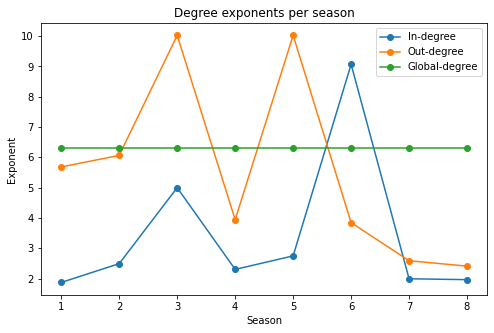

In [120]:
in_exps = []
out_exps = []
glob_exps = []

for s,GS in enumerate(seasons_G):
    in_exp = pl.Fit(list(Counter(list(dict(GS.in_degree()).values())).values())).alpha
    out_exp = pl.Fit(list(Counter(list(dict(GS.out_degree()).values())).values())).alpha
    tot_exp = pl.Fit(list(Counter(list(dict(G.degree()).values())).values())).alpha
    
    in_exps.append(in_exp)
    out_exps.append(out_exp)
    glob_exps.append(tot_exp)
    
plt.figure(figsize=(8,5))
plt.plot(range(1,9), in_exps, 'o-', label="In-degree")
plt.plot(range(1,9), out_exps, 'o-', label="Out-degree")
plt.plot(range(1,9), glob_exps, 'o-', label="Global-degree")
plt.legend()
plt.title("Degree exponents per season")
plt.xlabel("Season")
plt.ylabel("Exponent")
plt.show()

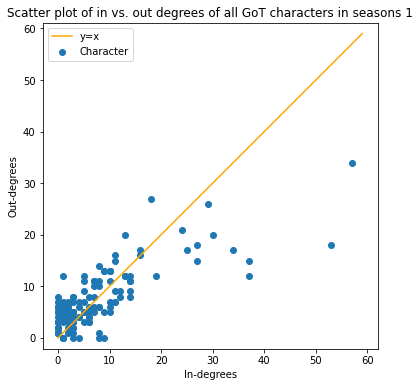

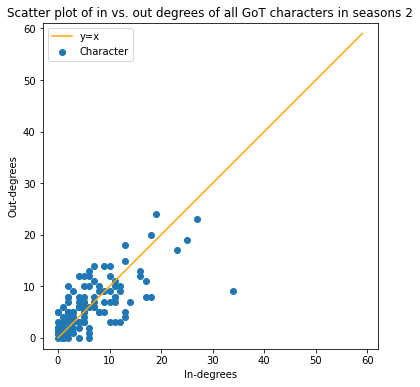

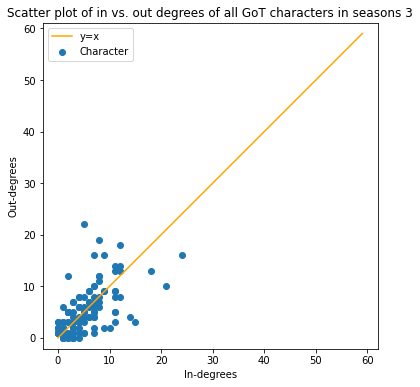

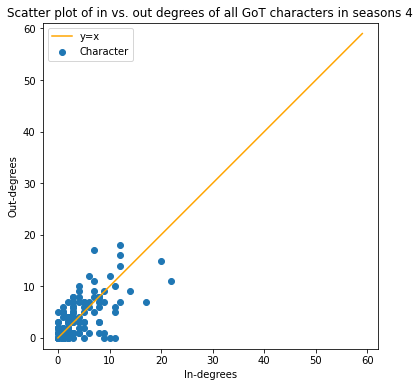

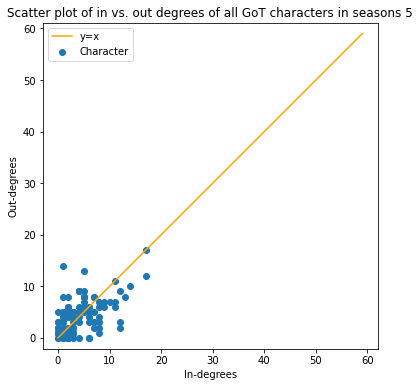

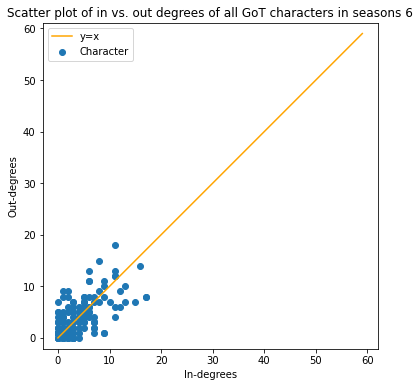

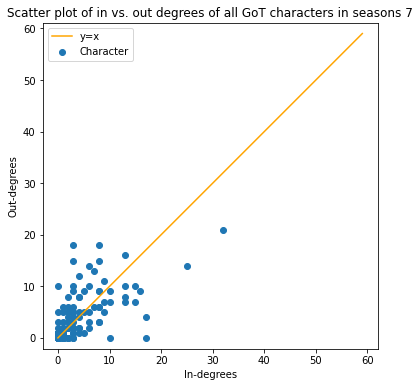

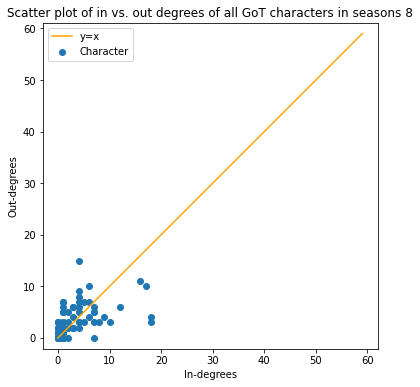

In [121]:
for s,GS in enumerate(seasons_G):
    in_degs = list(dict(GS.in_degree()).values())
    out_degs = list(dict(GS.out_degree()).values())
    
    line = list(range(0,60))

    plt.figure(figsize=(6,6))
    plt.scatter(in_degs, out_degs, label="Character")
    plt.plot(line, line, color='orange', label='y=x')
    plt.axis("equal")
    plt.legend()
    plt.xlabel("In-degrees")
    plt.ylabel("Out-degrees")
    plt.title(f"Scatter plot of in vs. out degrees of all GoT characters in seasons {s+1}")
    plt.show()

### Per season TF-IDF



In [122]:
### Try TF-IDF per seasons to see if there are words that characterize each season

# Dictionnary with the list of words of each community
seasons_words = [None for _ in range(8)]

for s in range(8):
    chars_list_s = os.listdir(f"Season {s+1}")
    chars_list_s.remove(".DS_Store")
    chars_list_s = [char[:-4] for char in chars_list_s]
    words = []
    
    for char in chars_list_s:
        f = open(f'Season {s+1}/{char}.txt')
        words = words + re.findall(r"\w+", f.read())
        f.close()
    seasons_words[s] = words

# Lower case all the words
for s in range(8):
    seasons_words[s] = [w.lower() for w in seasons_words[s]]

In [123]:
### Create a dictionnary with the IDF of all the words from the top 10 communities
IDF_seasons = {}

re_run_idf = False   # Put to True to regenerate the idf of each word of the 10 commnities

if re_run_idf:
    # List of unique words from the 10 communities
    all_words = []
    for s in seasons_words:
        all_words = all_words + s
    all_words = list(set(all_words))

    # Calculate the IDF of every word in the 10 communities
    # /!\/!\ very long to run /!\/!\

    for w in all_words:
        d = 0
        for s in seasons_words:
            if w in s:
                d += 1
        IDF_seasons[w] = np.log(8/d)

    # Save IDF dict to txtfile
    with open("IDF_seasons.txt", "w") as file:
        for word in IDF_seasons:
            file.write(word+";"+str(IDF_seasons[word])+"\n")
        file.close()

else:
    # Get the IDF dictionnary from the text file where it is stored
    with open("IDF_seasons.txt", "r") as file:
        for line in file:
            sp = line.split(";")
            IDF_seasons[sp[0]] = float(sp[1][:-1])
        file.close()

In [124]:
# Now calculate the TF-IDF for all the words in all the communities
TFIDF_seasons = [None for _ in range(8)]
for s in range(8):
    TFIDF_seas = {}
    TF_seas = dict(nltk.FreqDist(seasons_words[s]))
    for w in list(TF_seas.keys()):
        TFIDF_seas[w] = TF_seas[w]*IDF_seasons[w]
    TFIDF_seas = {key: val for key, val in sorted(TFIDF_seas.items(), key = lambda ele: ele[1], reverse=True)}
    TFIDF_seasons[s] = TFIDF_seas

In [125]:
# Print top 10 TF-IDF words for each community
for s in range(8):
    print(f"Top 10 highest TF-IDF in season {s+1} :")
    for w in list(TFIDF_seasons[s].keys())[:10]:
        print("  ",w, TFIDF_seasons[s][w])
    print('')

Top 10 highest TF-IDF in season 1 :
   jory 81.09822012551359
   pointy 77.63248422271387
   cripples 76.24618986159398
   pups 62.383246250395075
   duur 58.224363167035406
   mordane 51.986038541995896
   irri 51.29289136143595
   mago 45.747713916956386
   doreah 44.3614195558365
   hugh 43.66827237527655

Top 10 highest TF-IDF in season 2 :
   xaro 203.7852710846239
   garden 123.38019813967026
   pyat 108.13096016735146
   pree 103.97207708399179
   lorch 83.17766166719343
   amory 66.54212933375474
   doreah 62.383246250395075
   dagmer 54.06548008367573
   thirteen 52.67918572255584
   yoren 51.003121156609765

Top 10 highest TF-IDF in season 3 :
   maiden 170.51420641774652
   kraznys 116.4487263340708
   castamere 91.21712053009054
   rains 89.25546202406709
   mhysa 81.79136730607354
   orell 74.8598955004741
   edmure 71.39415959767436
   roslin 69.31471805599453
   locke 68.65804771082084
   jojen 65.15583497263486

Top 10 highest TF-IDF in season 4 :
   oberyn 106.69082383

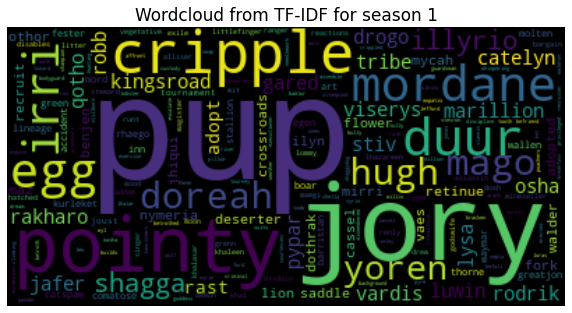

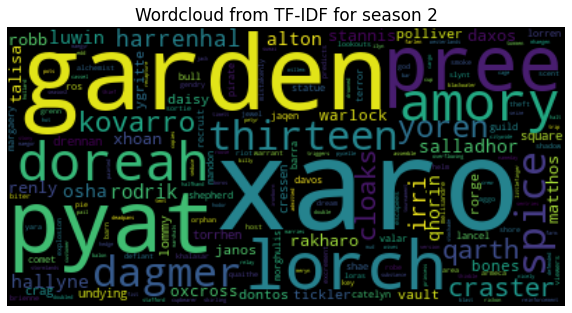

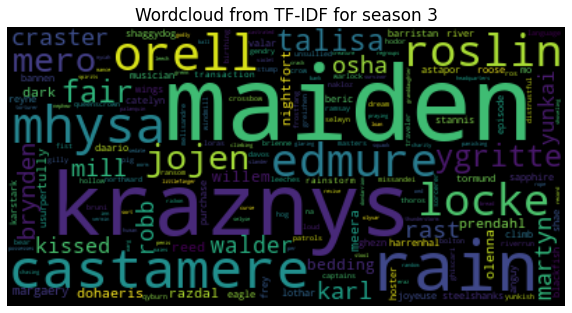

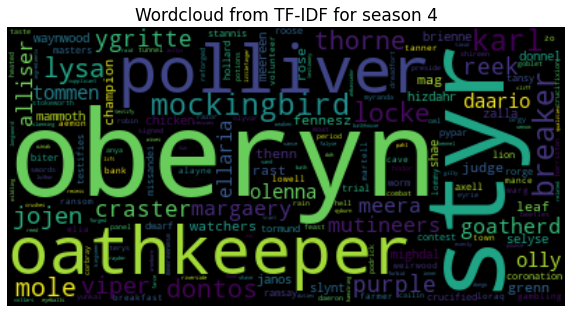

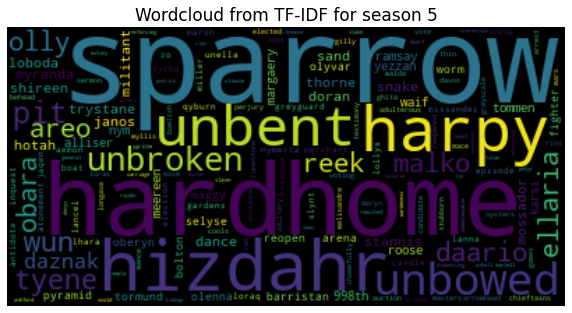

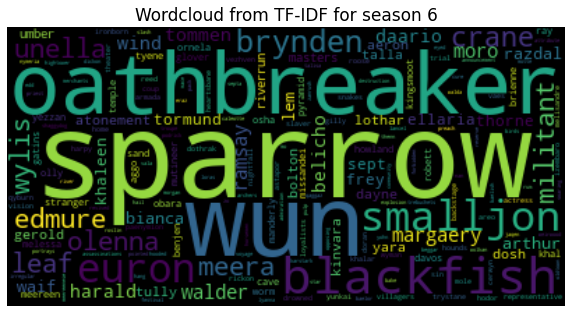

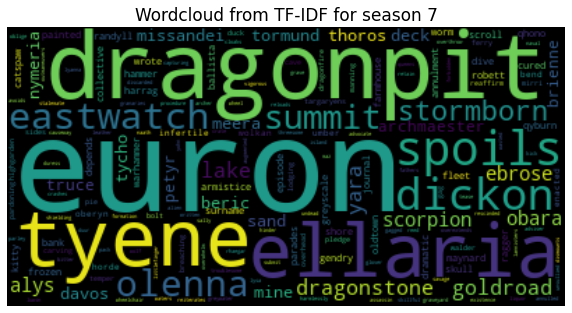

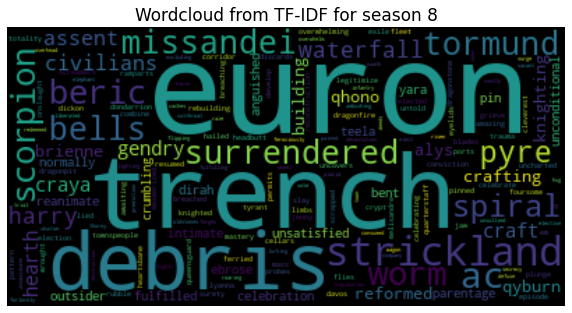

In [126]:
for s in range(8):
    wc_list = []
    # Add words to the list in proportion to their TD-IDF
    for w in list(set(seasons_words[s])):
        for i in range(int(10*TFIDF_seasons[s][w])):
            wc_list.append(w)
    wc = WordCloud(collocations = False).generate(' '.join(wc_list))

    plt.figure(figsize=(10,6))
    plt.title(f"Wordcloud from TF-IDF for season {s+1}", fontsize=17)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

It seems that the words highlighted by TF-IDF are meaningful since they target events of the seasons, like the 6 direwolf pups that the Starks find and keep in season 1. 
However,the main events of the story are not captured since they involve characters who are important in the show during all the seasons most of the time. Even Ned Stark who dies in the first is important for the whole storyline.

### Community and temporal patterns study

We have seen that the communities that we made with python's Louvain do not match the houses of Game of Throne, but from the word cloud they seem to match geographical or temporal patterns.
In this part, we try to cross the information about each season and the communities to confirm or infirm this analysis.

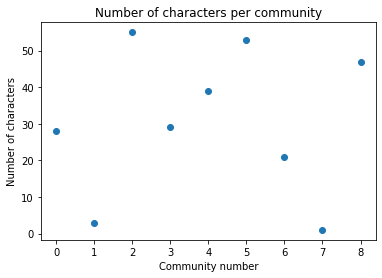

In [127]:
# Numbers of characters per community
ccom = {key: val for key, val in sorted(dict(c).items(), key = lambda ele: ele[0], reverse=False)}

plt.figure()
plt.plot(list(ccom.keys()), ccom.values(), "o")
plt.xlabel("Community number")
plt.ylabel("Number of characters")
plt.title("Number of characters per community")
plt.show()

In [133]:
# Why do 2 communities have a very low number of characters
print("Characters of community 1 :")
for char in part:
    if part[char] == 1:
        print(f"   {char}")

print("\nCharacter of community 7 :")
for char in part:
    if part[char] == 7:
        print(f"   {char}")

Characters of community 1 :
   Aegon II Targaryen
   Viserys I Targaryen
   Rhaenys Targaryen

Character of community 7 :
   Handmaiden


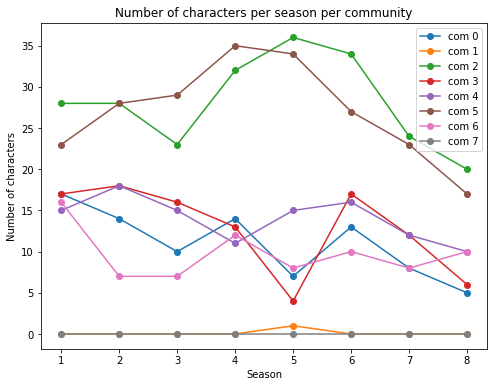

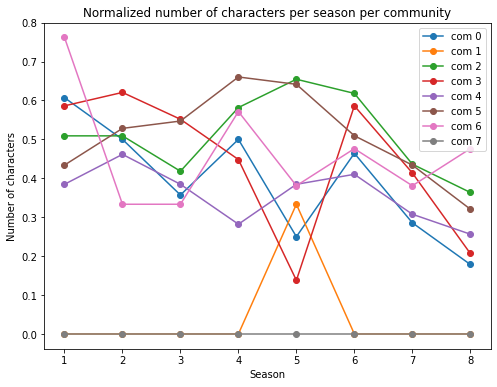

In [134]:
# Number of characters across seasons in each community
# Each line represents a community and each column a season
sv = np.zeros((9,8))

for char in part:
    com = part[char]
    for s in range(8):
        if char in seasons_G[s].nodes():
            sv[com,s] += 1


plt.figure(figsize=(8,6))
for s in range(8):
    plt.plot(x, sv[s], "o-", label=f"com {s}")
plt.xlabel("Season")
plt.ylabel("Number of characters")
plt.legend()
plt.title("Number of characters per season per community")
plt.show()

plt.figure(figsize=(8,6))
for s in range(8):
    plt.plot(x, [v/c[s] for v in sv[s]], "o-", label=f"com {s}")
plt.xlabel("Season")
plt.ylabel("Number of characters")
plt.legend()
plt.title("Normalized number of characters per season per community")
plt.show()

In [135]:
allchars = list(part.keys())
coms = list(part.values())
degs = [G.degree()[char] for char in allchars]

com_importance_cor = sc.pearsonr(coms, degs)
com_importance_cor

PearsonRResult(statistic=0.07103677198088151, pvalue=0.2394822011669357)

The community the characters belong to and their degree are not correlated, so it means that there are important characters in several communities, which is pretty understandable because the characters who play an important part in the show belong to different houses and are involved in different actions many times. 

## Twitter sentiment analysis

### Overview

This part aims at the analisis of tweets from differents seasons of GameOfThrones. The main goal for this is to perform a simple sentiment analysis to gauge the overarching sentiment (positive, negative, neutral) for a collection of tweets, and explore several visualization methods to gain additional insight from the analysis.
* Gathering of the tweets. 
* Proper Analisis

In the first part, we want to gather our database.  

In the second part we will do our analisis with some interesting libraries

### Part 1: Gathering of the Tweets

Ok. Usually Twitter gives you some credentials API in order to gather tweets. The issue is the basic API only allowed you to take recent tweets. Since GameOfThrones season 1 is not at all recent we need to search for other ways.
> 
> **Video **: https://www.youtube.com/watch?v=jtIMnmbnOFo&ab_channel=AISpectrum 
> 

In [ ]:
from datetime import date, timedelta
import snscrape.modules.twitter as sntwitter
import pandas as pd

In [ ]:
#listOfDays is a list of queries for every day that we want to gather tweets
#name is the place where you want to store the data
#This function gather 5000 tweets for everyday in our list of listOfday

def get_tweets_of_a_season(listOfDays,name):
    tweets = []
    limit = 5000
    for query in listOfDays:

        for tweet in sntwitter.TwitterSearchScraper(query).get_items():

            # print(vars(tweet))
            # break
            if len(tweets) == limit:
                break
            else:
                tweets.append([tweet.date, tweet.username, tweet.content])
        limit=limit+5000

    df = pd.DataFrame(tweets, columns=['created_at', 'User', 'text'])
    print(df)

    # to save to csv
    df.to_csv(name)    

In [ ]:
def get_listOfDays(start_date, end_date):
    nb_days=end_date-start_date
    listOfDays=[]
    for i in range(nb_days.days+1):
        strin=f'(#GameofThrones) lang:en until:{end_date} since:{start_date}' #our general query: english that have the hashtag #GameofThrones between dates
        end_date=end_date-timedelta(days=1)
        listOfDays.append(strin)
        
    return listOfDays
    

#### SEASON 1

In [ ]:
start_date=date(2011, 4,15)
end_date=date(2011,6,21)
listOfDays=get_listOfDays(start_date,end_date)
get_tweets_of_a_season(listOfDays,'tweetsseason1.csv')

#### SEASON 3

In [ ]:
start_date=date(2013, 3,29)
end_date=date(2013,6,11)
listOfDays=get_listOfDays(start_date,end_date)
get_tweets_of_a_season(listOfDays,'tweetsseason3.csv')

#### SEASON 8

we could use the same method but we found in the internet a much better database of 760659 tweets 
 > https://www.kaggle.com/datasets/monogenea/game-of-thrones-twitter


### Part 2: Analisis of the Tweets

There are a lot of ways to analyse tweets. We decided to use two ways in order to compare our results
There is on the internet a guy who has made an analisis of the season 8 tweets. 
>this is his link: https://github.com/ItsBigSchub/GoT-Sentiment-Analysis/blob/main/GOT_EVA.ipynb

In [ ]:
# Import all the necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
nltk.download('twitter_samples') # dataset used to train the model
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
nltk.download('punkt')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords, twitter_samples
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk import classify, NaiveBayesClassifier
import re, string
from wordcloud import WordCloud,STOPWORDS
from textblob import TextBlob
# Import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta
from wordcloud import WordCloud, STOPWORDS
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords, twitter_samples
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk import FreqDist, classify, NaiveBayesClassifier
import re, string, random


[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\ullmo\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ullmo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ullmo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ullmo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ullmo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ullmo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-

#### TextBlob

In [ ]:
#tweet a string
def clean_tweet( tweet):
        '''
        Utility function to clean tweet text by removing links, special characters
        using simple regex statements.
        '''
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

In [ ]:
#tweet a string

def get_tweet_sentiment( tweet):
        '''
        Utility function to classify sentiment of passed tweet
        using textblob's sentiment method
        '''
        # create TextBlob object of passed tweet text
        analysis = TextBlob(clean_tweet(tweet))
        # set sentiment
        if analysis.sentiment.polarity > 0:
            return 'positive'
        elif analysis.sentiment.polarity == 0:
            return 'neutral'
        else:
            return 'negative'

In [ ]:
#tweets a database of tweets
#name where to store the new database
def analise_sentiments(tweets,name):
    got_sent = []
    for tokens in tweet.text:
        got_sent.append(get_tweet_sentiment(tokens))
    
    tweet['sentiment'] = got_sent
    tweet.to_csv(name, index=False)

    

In [ ]:
def formatting(tweet):
    tweet['created_at'] = pd.to_datetime(tweet['created_at'], format='%Y-%m-%d %H:%M:%S')
    tweet = tweet.sort_values(by='created_at') # sort the dataframe by the time of each tweet
    tweet.set_index('created_at', drop=False, inplace=True) # set the time the tweet was created at as the index
    got_day = pd.DataFrame(tweet[['created_at', 'sentiment']].groupby(pd.Grouper(freq='1d', offset='12h'))['sentiment'].value_counts())
    got_day.rename(columns={'sentiment':'count'}, inplace=True) # rename the columns to be 'sentiment' and 'count' for each day
    got_day.reset_index(inplace=True) # reset the index
    # Create new columns for positive and negative sentiment instead of having 'sentiment' and 'count'
    got_day = pd.concat([got_day,pd.get_dummies(got_day['sentiment'])], axis=1)
    
    # Move the count for each sentiment into the new columns so that for each value 
    # in the 'created_at' column there is a value for Negative and Positive
    for i in range(len(got_day)):
        if got_day['sentiment'].iloc[i] == 'positive':
            got_day['positive'].iloc[i] = got_day['count'].iloc[i]
        elif got_day['sentiment'].iloc[i] == 'negative':
            got_day['negative'].iloc[i] = got_day['count'].iloc[i]
        else:
            got_day['neutral'].iloc[i] = got_day['count'].iloc[i]
    got_day.drop(['sentiment', 'count'], axis=1, inplace=True) # drop the old columns
    got_day = got_day.groupby('created_at').sum() # combine the separate negative and positive rows into a single row for each day
    got_day.reset_index(inplace=True)
    
    # Correct the 'created_at' time back to the beginning of each day 
    # This accounts for the offset when grouping and helps with plotting
    got_day['created_at'] = got_day['created_at'] - timedelta(hours=12)
    return got_day

In [ ]:
def plotting(got_day,name):
    x = timedelta(hours=4.5) # used to offset the positive tweets to compare side by side

    fig, ax = plt.subplots(1, 1, figsize=(15,6))
    pos = ax.bar(got_day['created_at']-x, got_day['positive'], width=0.45, align='center', label='Positive')
    neg = ax.bar(got_day['created_at']+x, got_day['negative'], width=0.45, align='center', label='Negative')
    neutral=ax.bar(got_day['created_at']+x, got_day['neutral'], width=0.45, align='center', label='Neutral')
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.SUNDAY, interval=1)) # set major tick labels to be on Sundays
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%y'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    ax.set_title(name, fontsize=15)
    ax.legend()
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Tweets', fontsize=12)
    ax.grid()

C:\Users\ullmo\AppData\Local\Temp/ipykernel_23892/1075173226.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  got_day['neutral'].iloc[i] = got_day['count'].iloc[i]
C:\Users\ullmo\AppData\Local\Temp/ipykernel_23892/1075173226.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  got_day['positive'].iloc[i] = got_day['count'].iloc[i]
C:\Users\ullmo\AppData\Local\Temp/ipykernel_23892/1075173226.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

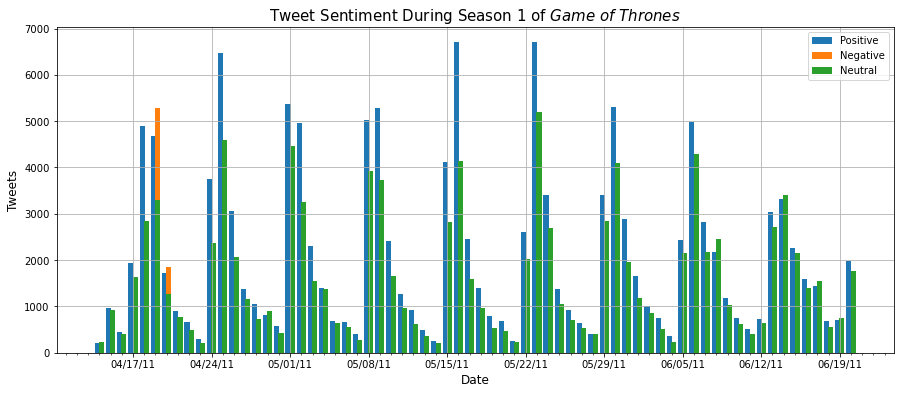

In [ ]:
#Season 1
tweet = pd.read_csv('tweetsseason1.csv')
analise_sentiments(tweet,'tweetsseason1.csv')
got_day=formatting(tweet)
plotting(got_day,'Tweet Sentiment During Season 1 of $\it{Game}$ $\it{of}$ $\it{Thrones}$')

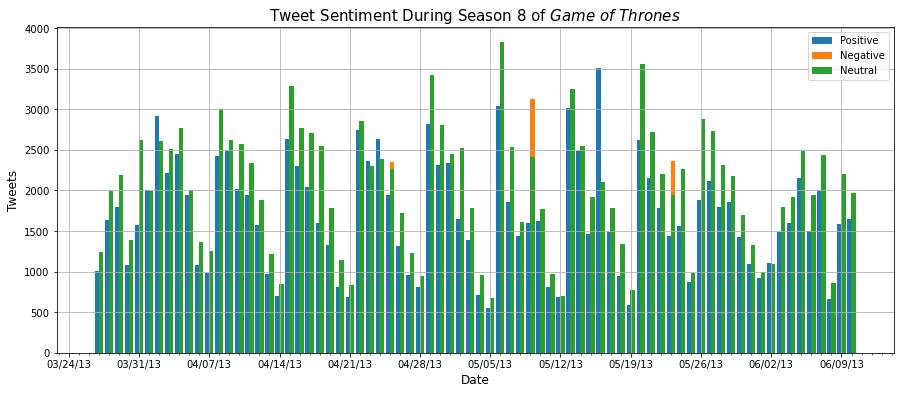

In [ ]:


#Season 3
tweet = pd.read_csv('tweetsseason3.csv')
analise_sentiments(tweet,'tweetsseason3.csv')
got_day=formatting(tweet)
plotting(got_day,'Tweet Sentiment During Season 3 of $\it{Game}$ $\it{of}$ $\it{Thrones}$')



C:\Users\ullmo\AppData\Local\Temp/ipykernel_23892/3943814395.py:2: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  tweet = pd.read_csv('../files/gotTwitter.csv')
C:\Users\ullmo\AppData\Local\Temp/ipykernel_23892/1075173226.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  got_day['negative'].iloc[i] = got_day['count'].iloc[i]
C:\Users\ullmo\AppData\Local\Temp/ipykernel_23892/1075173226.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  got_day['positive'].iloc[i] = got_day['count'].iloc[i]
C:\Users\ullmo\AppData\Local\Temp/ipykernel_23892/1075173226.py:19: Set

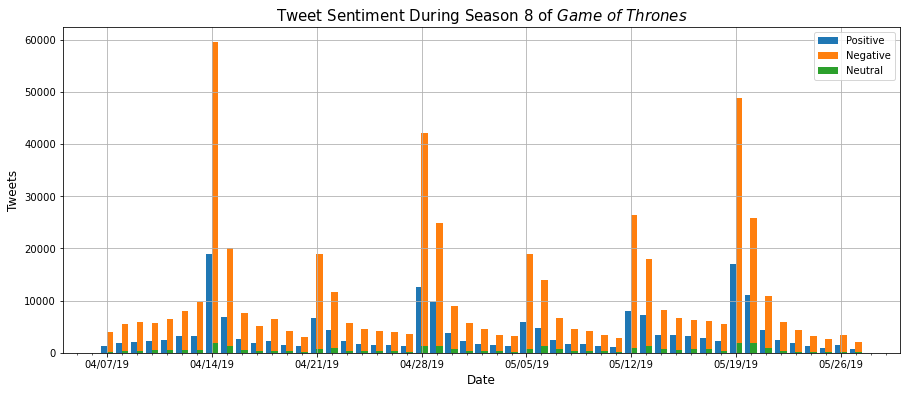

In [ ]:
#Season 8
tweet = pd.read_csv('../files/gotTwitter.csv')
analise_sentiments(tweet,'tweetsseason8.csv')
got_day=formatting(tweet)
plotting(got_day,'Tweet Sentiment During Season 8 of $\it{Game}$ $\it{of}$ $\it{Thrones}$')



#### Machine learning
> this is inspired by the code of ItsBigSchub. We think it is relevant to compare his analisis of season 8 for other seasons


In [ ]:
# Import all the necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
nltk.download('twitter_samples') # dataset used to train the model
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
nltk.download('punkt')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords, twitter_samples
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk import classify, NaiveBayesClassifier
import re, string
from wordcloud import WordCloud,STOPWORDS

[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\ullmo\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ullmo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ullmo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ullmo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ullmo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ullmo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-

In [ ]:
stop_words = stopwords.words('english')

positive_tokens = twitter_samples.tokenized('positive_tweets.json')
negative_tokens = twitter_samples.tokenized('negative_tweets.json')

In [ ]:
positive_cleaned_tokens = []
for i in range(len(positive_tokens)):
  row_token = []
  for token, tag in pos_tag(positive_tokens[i]):
    token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                    '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token) # remove any hyperlinks
    token = re.sub('(@[A-Za-z0-9_]+)','', token) # remove any twitter handles
    if tag.startswith('NN'): # assigning nouns
      pos = 'n'
    elif tag.startswith('VB'): # assigning verbs
      pos = 'v'
    else: # assigning adjectives
      pos = 'a'
    lemmatizer = WordNetLemmatizer()
    token = lemmatizer.lemmatize(token, pos) # lemmatize the token
    if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
      row_token.append(token.lower()) # save the token to the row (tweet)
  positive_cleaned_tokens.append(row_token) # save the row (tweet) to the list of cleaned tweets

In [ ]:
negative_cleaned_tokens = []
for i in range(len(negative_tokens)):
  row_token = []
  for token, tag in pos_tag(negative_tokens[i]):
    token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                    '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token) # remove any hyperlinks
    token = re.sub('(@[A-Za-z0-9_]+)','', token) # remove any twitter handles
    if tag.startswith('NN'): # assigning nouns
      pos = 'n'
    elif tag.startswith('VB'): # assigning verbs
      pos = 'v'
    else: # assigning adjectives
      pos = 'a'
    lemmatizer = WordNetLemmatizer()
    token = lemmatizer.lemmatize(token, pos) # lemmatize the token
    if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
      row_token.append(token.lower()) # save the token to the row (tweet)
  negative_cleaned_tokens.append(row_token) # save the row (tweet) to the list of cleaned tweets

In [ ]:
# Define the function to put the tweet tokens into a dictionary
def get_tweets_for_model(cleaned_tokens_list):
  for tweet_tokens in cleaned_tokens_list:
    yield dict([token, True] for token in tweet_tokens)

In [ ]:
# Run the function on both datasets
positive_tokens_for_model = get_tweets_for_model(positive_cleaned_tokens)
negative_tokens_for_model = get_tweets_for_model(negative_cleaned_tokens)

In [ ]:
positive_dataset = [(tweet_dict, "Positive")
                     for tweet_dict in positive_tokens_for_model]

negative_dataset = [(tweet_dict, "Negative")
                     for tweet_dict in negative_tokens_for_model]

dataset = positive_dataset + negative_dataset

train_data, test_data = train_test_split(dataset, test_size=0.3, random_state=10)

In [ ]:
classifier = NaiveBayesClassifier.train(train_data)

print("Accuracy is:", classify.accuracy(classifier, test_data))

print(classifier.show_most_informative_features(10))

Accuracy is: 0.9966666666666667
Most Informative Features
                      :( = True           Negati : Positi =   2032.2 : 1.0
                      :) = True           Positi : Negati =   1007.5 : 1.0
                follower = True           Positi : Negati =     39.9 : 1.0
                     sad = True           Negati : Positi =     33.8 : 1.0
                     x15 = True           Negati : Positi =     17.3 : 1.0
               community = True           Positi : Negati =     16.0 : 1.0
                      aw = True           Negati : Positi =     12.7 : 1.0
                   didnt = True           Negati : Positi =     11.4 : 1.0
                    glad = True           Positi : Negati =     11.3 : 1.0
               goodnight = True           Positi : Negati =     10.6 : 1.0
None


In [ ]:
#tweets a database of tweets
#name where to store the new database
def analise_sentiments2(tweets,name):
    got_text = tweets['text'].to_numpy()

    # Set up the tweet tokenizer
    tweet_tokenizer = TweetTokenizer()

    got_tokens = []

    # Tokenize the tweets
    for sent in got_text:
        got_tokens.append(tweet_tokenizer.tokenize(sent))
    
    
    cleaned_tokens = []
    for i in range(len(got_tokens)):
        row_token = []
        for token, tag in pos_tag(got_tokens[i]):
            token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                            '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token) # remove any hyperlinks
            token = re.sub('(@[A-Za-z0-9_]+)','', token) # remove any twitter handles
            if tag.startswith('NN'): # assigning nouns
                pos = 'n'
            elif tag.startswith('VB'): # assigning verbs
                pos = 'v'
            else: # assigning adjectives
                pos = 'a'
            lemmatizer = WordNetLemmatizer()
            token = lemmatizer.lemmatize(token, pos) # lemmatize the token
            if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
                row_token.append(token.lower()) # save the token to the row (tweet)
        cleaned_tokens.append(row_token) # save the row (tweet) to the list of cleaned tweets
    
    got_sent = []
    for tokens in cleaned_tokens:
        got_dict = dict([token, True] for token in tokens)
        got_sent.append(classifier.classify(got_dict))
    tweets['sentiment'] = got_sent
    tweets.to_csv(name, index=False)

In [ ]:
def formatting2(tweet):
    tweet['created_at'] = pd.to_datetime(tweet['created_at'], format='%Y-%m-%d %H:%M:%S')
    tweet = tweet.sort_values(by='created_at') # sort the dataframe by the time of each tweet
    tweet.set_index('created_at', drop=False, inplace=True) # set the time the tweet was created at as the index
    got_day = pd.DataFrame(tweet[['created_at', 'sentiment']].groupby(pd.Grouper(freq='1d', offset='12h'))['sentiment'].value_counts())
    got_day.rename(columns={'sentiment':'count'}, inplace=True) # rename the columns to be 'sentiment' and 'count' for each day
    got_day.reset_index(inplace=True) # reset the index
    # Create new columns for positive and negative sentiment instead of having 'sentiment' and 'count'
    got_day = pd.concat([got_day,pd.get_dummies(got_day['sentiment'])], axis=1)
    
    # Move the count for each sentiment into the new columns so that for each value 
    # in the 'created_at' column there is a value for Negative and Positive
    for i in range(len(got_day)):
        if got_day['sentiment'].iloc[i] == 'Positive':
            got_day['Positive'].iloc[i] = got_day['count'].iloc[i]
        elif got_day['sentiment'].iloc[i] == 'Negative':
            got_day['Negative'].iloc[i] = got_day['count'].iloc[i]
        
    got_day.drop(['sentiment', 'count'], axis=1, inplace=True) # drop the old columns
    got_day = got_day.groupby('created_at').sum() # combine the separate negative and positive rows into a single row for each day
    got_day.reset_index(inplace=True)
    
    # Correct the 'created_at' time back to the beginning of each day 
    # This accounts for the offset when grouping and helps with plotting
    got_day['created_at'] = got_day['created_at'] - timedelta(hours=12)
    return got_day

In [ ]:
def plotting2(got_day,name):
    x = timedelta(hours=4.5) # used to offset the positive tweets to compare side by side

    fig, ax = plt.subplots(1, 1, figsize=(15,6))
    pos = ax.bar(got_day['created_at']-x, got_day['Positive'], width=0.45, align='center', label='Positive')
    neg = ax.bar(got_day['created_at']+x, got_day['Negative'], width=0.45, align='center', label='Negative')
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.SUNDAY, interval=1)) # set major tick labels to be on Sundays
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%y'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    ax.set_title(name, fontsize=15)
    ax.legend()
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Tweets', fontsize=12)
    ax.grid()

C:\Users\ullmo\AppData\Local\Temp/ipykernel_23892/2829591204.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  got_day['Positive'].iloc[i] = got_day['count'].iloc[i]
C:\Users\ullmo\AppData\Local\Temp/ipykernel_23892/2829591204.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  got_day['Negative'].iloc[i] = got_day['count'].iloc[i]


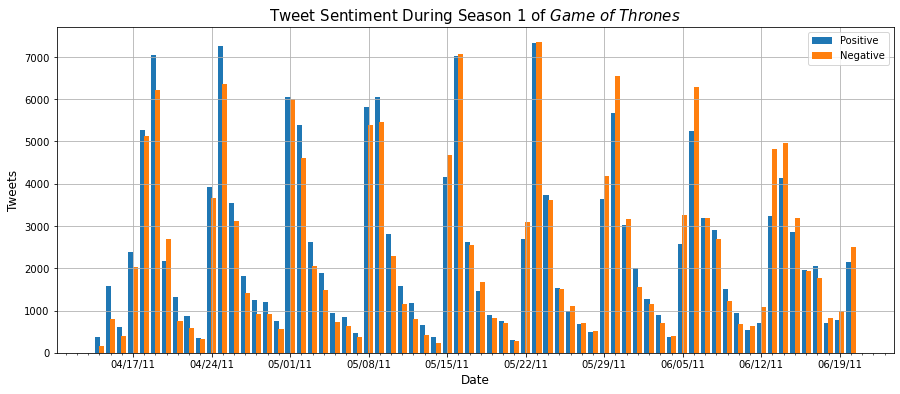

In [ ]:
#season1
tweet = pd.read_csv('tweetsseason1.csv')
analise_sentiments2(tweet,'tweetsseason1.csv')
got_day=formatting2(tweet)

plotting2(got_day,'Tweet Sentiment During Season 1 of $\it{Game}$ $\it{of}$ $\it{Thrones}$')


C:\Users\ullmo\AppData\Local\Temp/ipykernel_23892/2829591204.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  got_day['Positive'].iloc[i] = got_day['count'].iloc[i]
C:\Users\ullmo\AppData\Local\Temp/ipykernel_23892/2829591204.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  got_day['Negative'].iloc[i] = got_day['count'].iloc[i]


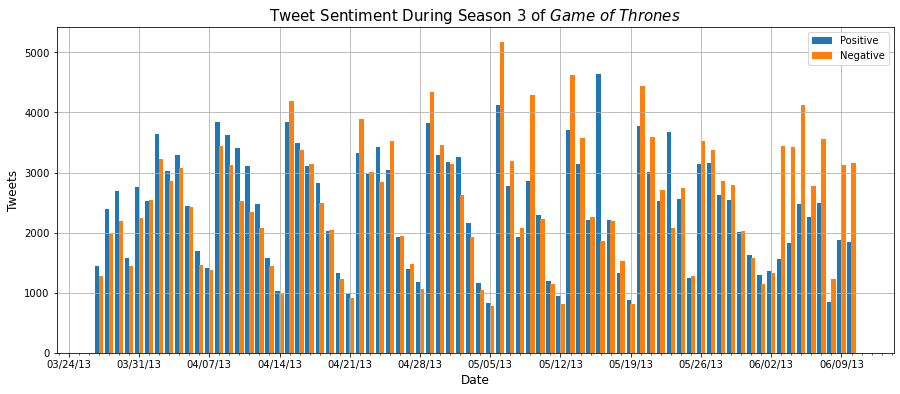

In [ ]:
#season3
tweet = pd.read_csv('tweetsseason3.csv')
analise_sentiments2(tweet,'tweetsseason3.csv')
got_day=formatting2(tweet)
plotting2(got_day,'Tweet Sentiment During Season 3 of $\it{Game}$ $\it{of}$ $\it{Thrones}$')

C:\Users\ullmo\AppData\Local\Temp/ipykernel_23892/871187608.py:2: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  tweet = pd.read_csv('../files/gotTwitter.csv')
C:\Users\ullmo\AppData\Local\Temp/ipykernel_23892/2829591204.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  got_day['Negative'].iloc[i] = got_day['count'].iloc[i]
C:\Users\ullmo\AppData\Local\Temp/ipykernel_23892/2829591204.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  got_day['Positive'].iloc[i] = got_day['count'].iloc[i]


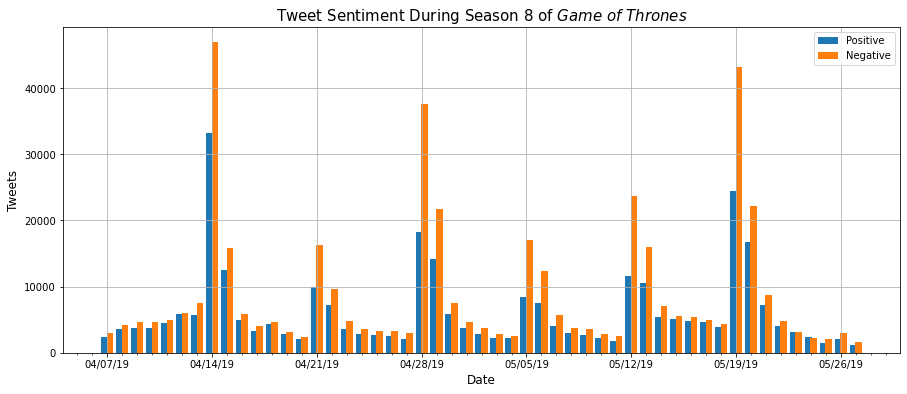

In [ ]:
#Season 8
tweet = pd.read_csv('../files/gotTwitter.csv')
analise_sentiments2(tweet,'tweetsseason8.csv')
got_day=formatting2(tweet)
plotting2(got_day,'Tweet Sentiment During Season 8 of $\it{Game}$ $\it{of}$ $\it{Thrones}$')

